In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
import random
from scipy.stats import pearsonr, spearmanr, kendalltau
import pingouin as pg #compute repeated measure correlation

#save and load dictionaries/lists
import pickle

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, ZoneVariable, time_series_henColumn_tsRow, FB_daily, corr_from_dep2feature,FB_process,\
corr_from_feature2feature, correlationGraph, ZoneVariable, DataRepresentation1, sampen, chi2_distance, is_day, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


# Define parameters

In [3]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
id_run = config.id_run
dico_pen_tr = config.dico_pen_tr
dico_HAID_date = config.dico_HAID_date
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
date_consistent_barn_schedule = config.date_consistent_barn_schedule
path_extracted_data_chapter2 = os.path.join(path_extracted_data,'chapter2')
#create a director if not existing
if not os.path.exists(path_extracted_data_chapter2):
    os.makedirs(path_extracted_data_chapter2)

change the configuration file if not done yet!


# Download variables

In [4]:
#weather conditions
path_weather = os.path.join(r'C:\Users\camil\Desktop\vm_exchange\PhD_Data\Weather_exp1','Weather_process.csv')
df_weather_h = pd.read_csv(path_weather, sep=';', parse_dates=['date','Timestamp'])
df_weather_h = df_weather_h.sort_values('Timestamp') 
df_weather_h = df_weather_h.drop(['date'], axis=1)
df_weather_h['Timestamp_weather'] = df_weather_h['Timestamp'].copy()
print(df_weather_h.shape)
display(df_weather_h.head(3))

(7293, 13)


,Timestamp,temperature,humidity,wind speed,Precipitation amount,query,Moon Phase calculator,hour,temperature_C,wind_speed_mpers,humidity_avgpercent,rain,Timestamp_weather
0,2020-09-29 00:00:00,"10 °C\n(12:00 am CEST | Tuesday, September 29,...",average: 100% (100%)\n(12:00 am CEST | Tuesday...,"2 m/s\n(12:00 am CEST | Tuesday, September 29,...","rain\n(12:00 am CEST | Tuesday, September 29, ...","Moon Phase calculatorSeptember 29, 2020 0h",| waxing gibbous moon\n91.87% illuminated,0,10,2,100,rain,2020-09-29 00:00:00
1,2020-09-29 01:00:00,"10 °C\n(1:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(1:00 am CEST | Tuesday,...","3 m/s\n(1:00 am CEST | Tuesday, September 29, ...","rain\n(1:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 1h",| waxing gibbous moon\n92.09% illuminated,1,10,3,100,rain,2020-09-29 01:00:00
2,2020-09-29 02:00:00,"10 °C\n(2:00 am CEST | Tuesday, September 29, ...","average: 100% (100%)\n(2:00 am CEST | Tuesday,...","3 m/s\n(2:00 am CEST | Tuesday, September 29, ...","rain\n(2:00 am CEST | Tuesday, September 29, 2...","Moon Phase calculatorSeptember 29, 2020 2h",| waxing gibbous moon\n92.30% illuminated,2,10,3,100,rain,2020-09-29 02:00:00


In [5]:
#focal birds information (one row per focal bird)
df_FB = pd.read_csv(os.path.join(path_extracted_data, id_run+'df_FOCALBIRDS.csv'), sep=';',
                    parse_dates=['InitialStartDate'], dayfirst=True)
print(df_FB.shape)
df_FB.head(3)

(232, 14)


,HenID,PenID,CLASS,R-Pen,InitialStartDate,early_death,29-09 weight,10-12 juin weight,weight 23-11-2020,weight 04-01-2021,weight 01-02-21,weight 12-04-21,weight 26-07-21,Treatment
0,hen_1,9,EPI,1.0,2020-06-10,0.0,1134.0,57.0,1696.5,1787.8,1800.9,NaN,NaN,OFH
1,hen_10,11,LEXP,1.0,2020-06-10,0.0,1070.0,70.4,1488.3,1628.4,1602.1,1587.2,1713.4,OFH
2,hen_100,5,EPI,3.0,2020-06-10,0.0,1182.0,80.5,1642.5,NaN,NaN,NaN,NaN,OFH


In [6]:
#info on selection process: 
#when possible (i.e. enough MEXP in each pens), 25% (resp.25%) of focal bird were selected randomly among the MEXP (resp. LEXP) 
#remaining 50% of focal animals were selected as a representative sample of the population (called here EPI, as part of a larger study
#with epigenetics analysis)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(12, 4)


,Treatment,R-Pen,CLASS,HenID
0,OFH,1.0,EPI,20
1,OFH,1.0,LEXP,9
2,OFH,1.0,MEXP,10
3,OFH,3.0,EPI,20
4,OFH,3.0,LEXP,8
5,OFH,3.0,MEXP,9
6,TRAN,2.0,EPI,21
7,TRAN,2.0,LEXP,10
8,TRAN,2.0,MEXP,6
9,TRAN,4.0,EPI,19


In [7]:
#KBF&severity
df_HA = pd.read_csv(os.path.join(path_extracted_data, 'df_all_HA.csv'), sep=';', parse_dates=['date'], dayfirst=True) 
df_HA['FeatherDamage'] = df_HA['Feathers'].map(lambda x: 100-x)
df_HA['date_HA'] = df_HA['date'].copy()
print(df_HA.shape)
#display(df_HA.groupby(['HAID'])['date'].agg(lambda x: set(x)).reset_index())
display(df_HA['HAID'].value_counts())
#info on date
display(df_HA.groupby(['HAID','date','WOA','DOA'])['HenID'].count().reset_index())
print(df_HA.shape)
df_HA.head(3)

(846, 60)


HA1    176
HA3    176
HA4    176
HA2    160
HA5    158
Name: HAID, dtype: int64

,HAID,date,WOA,DOA,HenID
0,HA1,2020-11-23,25.0,173.0,175
1,HA2,2021-01-04,31.0,215.0,160
2,HA3,2021-02-01,35.0,243.0,176
3,HA4,2021-04-12,45.0,313.0,176
4,HA5,2021-07-25,60.0,417.0,157


(846, 60)


,Person_toe,Time,PenID,FocalLegringName,BirdType,CombPecks,Toes,RFPododermatitis,RFBumblefoot,RFinjuries,...,random_order1,severity,has_gap,BirdID,uncertainty (0:certain:1 random),Unnamed: 9,Info,backpack,FeatherDamage,date_HA
0,M,09:30,pen9,42grey,normal,25.0,NaN,0.0,0.0,0.0,...,109.0,0,0.0,42grey9sb,NaN,NaN,"['', '42', 'grey', '9', 'sb']",sb,NaN,2020-11-23
1,Mark,14:54,pen9,66grey,normal,0.0,NaN,50.0,0.0,0.0,...,509.0,16,0.0,66grey9sp,NaN,NaN,"['', '66', 'grey', '9', 'sp']",sp,14.0,2021-02-01
2,Camille,10:30,pen5,2green,normal,130.0,NaN,25.0,0.0,0.0,...,428.0,4,0.0,2green5pp,NaN,NaN,"['', '2', 'green', '5', 'pp']",pp,8.0,2021-02-01


#check animals with 0 fractures throught recorded life
df_ = df_HA.groupby(['HenID'])['severity'].agg(lambda x: list(x)).reset_index()
df_['NOKBF'] = df_['severity'].map(lambda x: sum(x)==0) #& len(x)>3
display(df_['NOKBF'].value_counts())
display(df_.head(3))
display(df_[df_['NOKBF']])
#check animals with 0 fractures at HA 5
df_ = df_HA[df_HA['HAID']=='HA5']
df_.sort_values('severity')[['HenID','HAID','severity','has_gap']].head(15)
#152/157*100 = 96.8

In [8]:
#info on selection process: repartition of Rearing pen in laying pen across class
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12), dt.datetime(2020,9,29)])].shape)
print(df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].shape)
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','R-Pen','CLASS',
                                                                                                 'PenID'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(160, 14)
(150, 14)
(47, 5)


,Treatment,R-Pen,CLASS,PenID,HenID
0,OFH,1.0,EPI,3,5
1,OFH,1.0,EPI,5,5
2,OFH,1.0,EPI,9,5
3,OFH,1.0,EPI,11,5
4,OFH,1.0,LEXP,3,2
5,OFH,1.0,LEXP,5,3
6,OFH,1.0,LEXP,9,2
7,OFH,1.0,LEXP,11,2
8,OFH,1.0,MEXP,3,3
9,OFH,1.0,MEXP,5,2


In [9]:
#info on selection process: repartition of class in laying pen
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['Treatment','PenID','CLASS'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(24, 4)


,Treatment,PenID,CLASS,HenID
0,OFH,3,EPI,10
1,OFH,3,LEXP,5
2,OFH,3,MEXP,5
3,OFH,5,EPI,10
4,OFH,5,LEXP,4
5,OFH,5,MEXP,5
6,OFH,9,EPI,10
7,OFH,9,LEXP,5
8,OFH,9,MEXP,5
9,OFH,11,EPI,10


In [10]:
#info on selection process: uniform representation of rearing pen identity (RPenID) in each LPenID
df_info = df_FB[df_FB['InitialStartDate'].isin([dt.datetime(2020,6,10), dt.datetime(2020,6,12)])].groupby(['PenID','R-Pen'])['HenID'].count().reset_index()
print(df_info.shape)
df_info

(16, 3)


,PenID,R-Pen,HenID
0,3,1.0,10
1,3,3.0,10
2,4,2.0,9
3,4,4.0,9
4,5,1.0,10
5,5,3.0,9
6,8,2.0,9
7,8,4.0,8
8,9,1.0,10
9,9,3.0,10


In [11]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables_verified.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True)
print(df_daily.shape)
#removing HA days
df_daily = df_daily[~df_daily['level'].isin(list(config.dico_HAID_date.values()))]
print(df_daily.shape)
#removing days with closed WG (removing two vaccinations date)
df_daily = df_daily[~df_daily['level'].isin(list(config.close_dates))]
print(df_daily.shape)
#removing when we changed to summer time (in next cleing will be automatic)
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,3,28)]
print(df_daily.shape)
df_daily['vaccination_day'] = df_daily['level'].map(lambda x: config.dico_vaccinationDate_type.get(x,'No vaccination'))
display(df_daily['vaccination_day'].value_counts())
display(df_daily['Treatment'].unique())
df_daily['time_wg_open_h'] = df_daily['time_wg_open_sec'].map(lambda x: x/60/60)
df_daily['age'] = df_daily['level'].map(lambda x: (x-config.birth_date).days)
display(df_daily['WentinWG'].value_counts())
#li_mvt = ['duration_1_Zone_min','duration_2_Zone_min', 'duration_3_Zone_min', 'duration_4_Zone_min', 'duration_5_Zone_min','perc_1_Zone_while_WG_open',
#          'nbr_stays_2_Zone', 'nbr_stays_4_Zone','nbr_stays_3_Zone', 'nbr_stays_5_Zone','nbr_stays_1_Zone',
#          'in_WG_15mnAfterOpening', 'SleepingHeight','vertical_travel_distance','WentinWG','time_wg_open_h']
#df_daily = df_daily[['HenID','PenID','level','age', 'CLASS', 'DOA','WOA', 'DIB','WIB','Total_number_transition']+li_mvt]
#display(df_daily[df_daily.isna().any(axis=1)])
#df_daily = df_daily[df_daily['level']>date_consistent_barn_schedule] #only since consistent barn schedule
#after stable, after chapter 2
df_daily = df_daily[df_daily['level']>dt.datetime(2020,11,24)]#not the day after HA
dico_cl = {'EPI':'REXP','MEXP':'MEXP','LEXP':'LEXP','LEXPLOST':'REXP','MEXPLOST':'REXP','NewAfterEpi':'NewAfterEpi',
          'NewAfterEpiLOST':'REXP'}
df_daily['CLASS'] = df_daily['CLASS'].map(lambda x: dico_cl[x])
display(df_daily['CLASS'].value_counts())
if df_daily[df_daily.isna().any(axis=1)].shape[0]>0:
    print('ERROR: YOU HAVE SOME NAN TO TAKE CARE OF:')
    display(df_daily.isna().sum(axis=0).sort_values().tail(15))
    #display(df_daily[df_daily.isna().any(axis=1)].head(3))
    print(df_daily[df_daily.isna().any(axis=1)].shape)
print(df_daily.shape)
df_daily.head(3)

(39382, 82)
(39382, 82)
(38625, 82)
(38625, 82)


No vaccination    37840
IBMa5Nobilis        471
IB4/91Nobilis       158
Ecoli               156
Name: vaccination_day, dtype: int64

array(['TRAN', 'OFH'], dtype=object)

1    24887
0    13738
Name: WentinWG, dtype: int64

NewAfterEpi    9595
REXP           8500
MEXP           7164
LEXP           5817
Name: CLASS, dtype: int64

ERROR: YOU HAVE SOME NAN TO TAKE CARE OF:


mid_cum_Z4_sec_Morning             120
mid_cum_Z4_h_Morning               120
FirstTimestamp_3_Zone              143
FirstTimestamp_2_Zone              181
night_Max_duration_zones           296
night_level                        296
night_Total_number_transition      296
is_mvt_night                       296
SleepingHeight                     296
night_duration_Z5                  296
FirstTimestamp_5_Zone             1024
FeatherDamage_interp              6187
FirstTimestamp_1_Zone             9930
FirstTimestamp_1_Zone_sec         9930
R-Pen                            10178
dtype: int64

(20782, 85)
(31076, 85)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,duration_3_Zone_min,duration_4_Zone_min,duration_5_Zone_min,Has_been_toptier_wholeday,weekday,WentinWG,Sleeping_Uppest,vaccination_day,time_wg_open_h,age
53,hen_131,2020-11-25,54000.0,15.0,"[654.0, 24673.0, 15720.0, 3219.0, 9734.0]",29.0,6.0,18.0,46.0,1.0,...,262.000000,53.650000,162.233333,False,wednesday,1,1,No vaccination,6.250000,175
54,hen_131,2020-11-26,54000.0,15.0,"[280.0, 27891.0, 20572.0, 1632.0, 3625.0]",38.0,3.0,7.0,52.0,1.0,...,342.866667,27.200000,60.416667,False,thursday,1,1,No vaccination,6.500000,176
55,hen_131,2020-11-27,54000.0,15.0,"[1397.0, 23308.0, 15043.0, 3902.0, 10350.0]",28.0,7.0,19.0,43.0,3.0,...,250.716667,65.033333,172.500000,False,friday,1,1,No vaccination,6.333333,177


In [12]:
min(df_daily['WOA'].tolist()), max(df_daily['WOA'].tolist())

(25, 60)

# Visual of 5 mvt metrics

Series([], Name: PenID, dtype: int64)

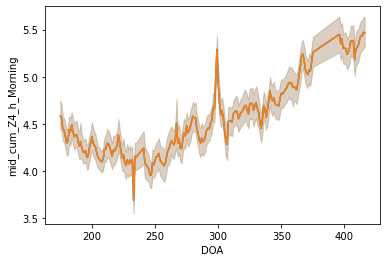

In [13]:
sns.lineplot(y='mid_cum_Z4_h_Morning', x='DOA', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. Because mini marker pen 3-5 did not worked on that day, maybe something else went wrong 
#that we did not detected, so I removed it
display(df_daily[df_daily['DOA']==219]['PenID'].value_counts())
df_daily = df_daily[df_daily['DOA']!=219]
sns.lineplot(y='mid_cum_Z4_h_Morning', x='DOA', data=df_daily);

Series([], Name: PenID, dtype: int64)

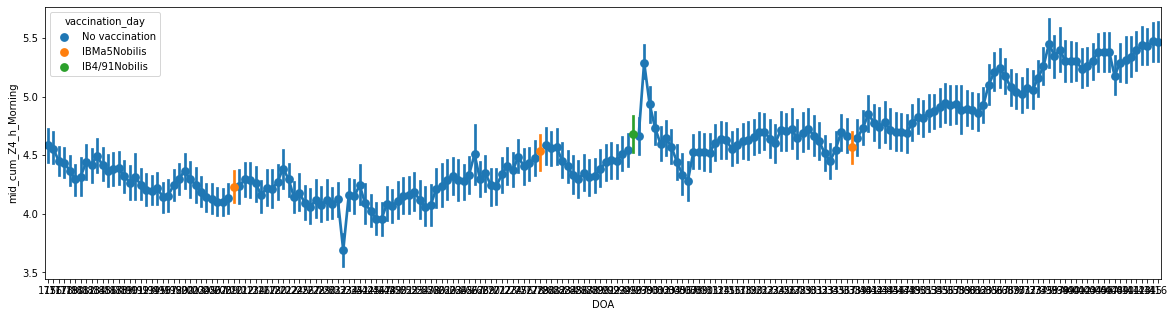

In [14]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='mid_cum_Z4_h_Morning', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

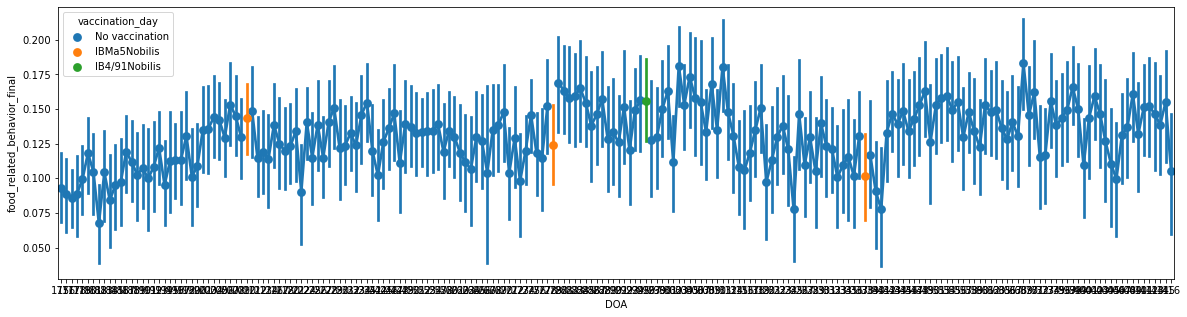

In [15]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='food_related_behavior_final', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

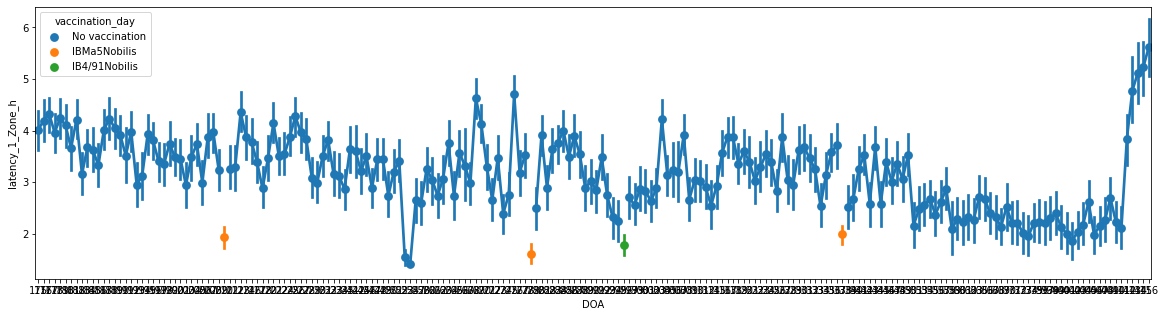

In [16]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='latency_1_Zone_h', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

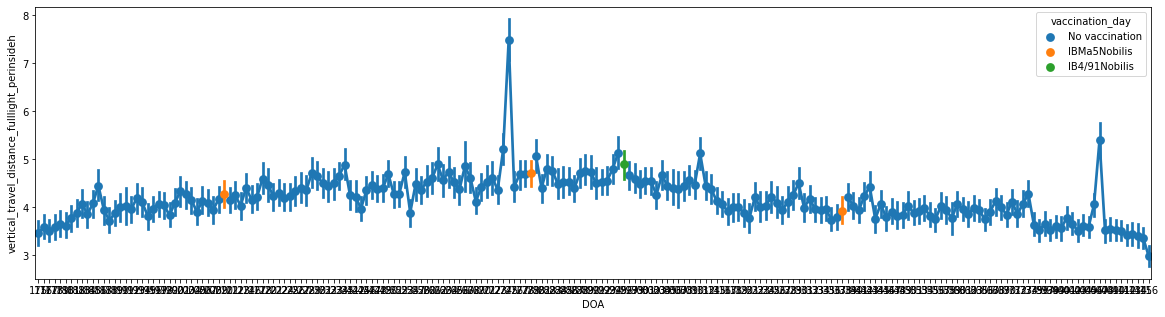

In [17]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='vertical_travel_distance_fulllight_perinsideh', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

Series([], Name: PenID, dtype: int64)

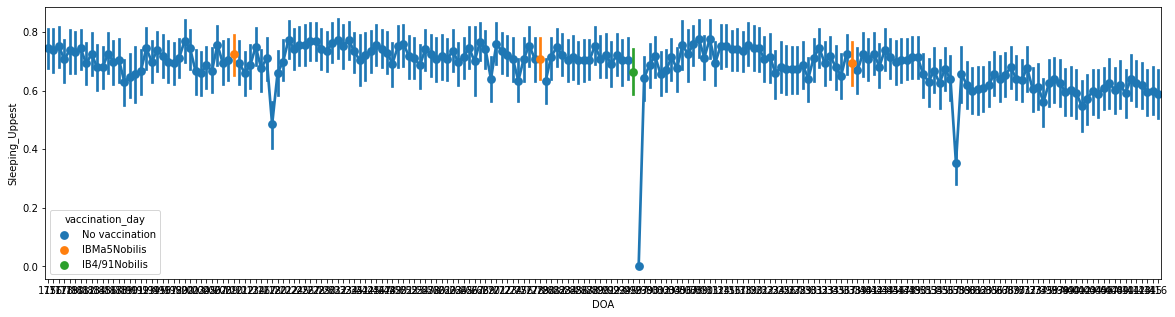

In [18]:
plt.figure(figsize=(20,5))
df_daily = df_daily[df_daily['DOA']!=219]
sns.pointplot(y='Sleeping_Uppest', x='DOA', hue='vaccination_day', data=df_daily);
#pick: display(df_daily[df_daily['DOA']==219][['level','PenID','HenID','mid_cum_Z4_h_Morning']].head(25))
#2021,1,8: dont know why. mini marker pen 3-5 did not worked so maybe something else too? should i remove it?
df_daily[df_daily['DOA']==219]['PenID'].value_counts()
#sns.scatterplot(y='mid_cum_Z4_h_Morning', x='DOA', color='red', data=df_daily[df_daily['vaccination_day']]);

In [19]:
#wg was closed on DOA 255, 256, dates dt.datetime(2021,2,13,0,0,0), dt.datetime(2021,2,14,0,0,0)
#df_daily[df_daily['DOA']==257][['DOA','temperature_C_avg','perc_duration_1_Zone','latency_1_Zone_h','PenID','HenID','level']]

# Add external temperature as environmental factor

In [20]:
#check variation over the day... exist very much
df_weather_h['date'] = df_weather_h['Timestamp'].map(lambda x: dt.datetime.date(x))
df_wday = df_weather_h[df_weather_h['hour'].isin([11,12,13,14,15,16])].groupby(['date'])['temperature_C'].agg(lambda x: list(x)).reset_index()
df_wday['temperature_C_avg'] = df_wday['temperature_C'].map(lambda x: np.mean(x))
display(df_wday.head(3))
#display(df_wday[df_wday['date']>=dt.date(2021,7,1)])

print(df_daily.shape)
df_daily['date'] = df_daily['level'].map(lambda x: dt.datetime.date(x))
df_daily = pd.merge(df_daily, df_wday, on='date', how='left')
print(df_daily.shape)
df_daily.head(2)

,date,temperature_C,temperature_C_avg
0,2020-09-29,"[11, 12, 12, 12, 12, 13]",12.0
1,2020-09-30,"[10, 11, 13, 13, 14, 14]",12.5
2,2020-10-01,"[13, 15, 15, 15, 15, 14]",14.5


(31076, 85)
(31076, 88)


,HenID,level,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,perc_duration_2_Zone,perc_duration_1_Zone,...,Has_been_toptier_wholeday,weekday,WentinWG,Sleeping_Uppest,vaccination_day,time_wg_open_h,age,date,temperature_C,temperature_C_avg
0,hen_131,2020-11-25,54000.0,15.0,"[654.0, 24673.0, 15720.0, 3219.0, 9734.0]",29.0,6.0,18.0,46.0,1.0,...,False,wednesday,1,1,No vaccination,6.25,175,2020-11-25,"[0, 1, 2, 2, 2, 2]",1.500000
1,hen_131,2020-11-26,54000.0,15.0,"[280.0, 27891.0, 20572.0, 1632.0, 3625.0]",38.0,3.0,7.0,52.0,1.0,...,False,thursday,1,1,No vaccination,6.50,176,2020-11-26,"[1, 3, 4, 4, 4, 3]",3.166667


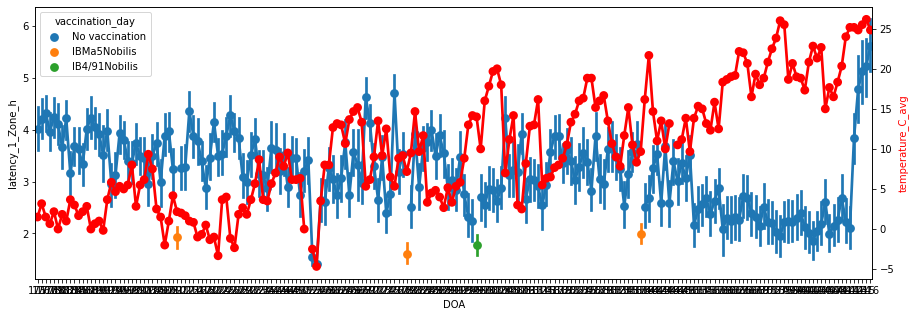

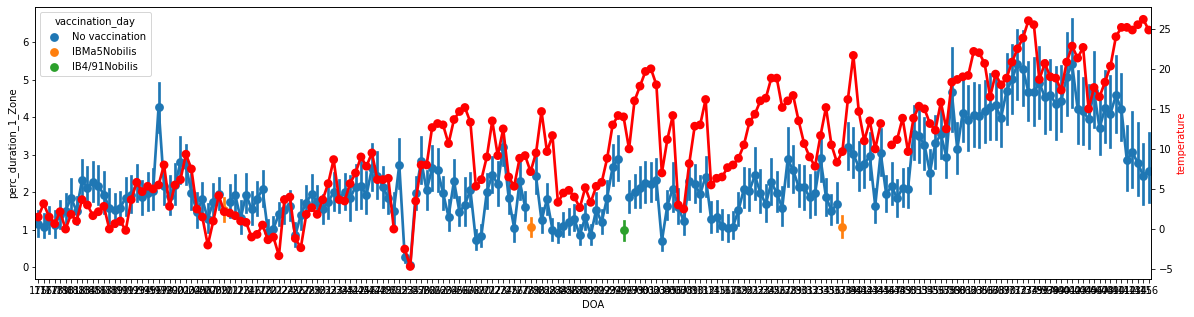

In [21]:
plt.figure(figsize=(15,5))
sns.pointplot(y='latency_1_Zone_h', x='DOA', hue='vaccination_day', size=0.3, alpha=0.4, data=df_daily);
ax2 = plt.twinx()
sns.pointplot(y='temperature_C_avg', x='DOA', color='red', size=0.3, alpha=0.4, data=df_daily, ax=ax2);
plt.ylabel("temperature_C_avg", color='red');
plt.show()

plt.figure(figsize=(20,5))
sns.pointplot(y='perc_duration_1_Zone', x='DOA', hue='vaccination_day', size=0.3, alpha=0.4, data=df_daily);
ax2 = plt.twinx()
sns.pointplot(y='temperature_C_avg', x='DOA', size=0.3,color='red', alpha=0.4, data=df_daily, ax=ax2);
plt.ylabel("temperature", color='red');

# Save weekly mvt for behavioural syndrome

In [22]:
df_daily[['HenID','level','latency_1_Zone_h','time_wg_open_h','perc_1_Zone_while_WG_open','duration_1_Zone_min']]

,HenID,level,latency_1_Zone_h,time_wg_open_h,perc_1_Zone_while_WG_open,duration_1_Zone_min
0,hen_131,2020-11-25,3.126111,6.250000,2.906667,10.900000
1,hen_131,2020-11-26,0.508889,6.500000,1.196581,4.666667
2,hen_131,2020-11-27,0.976389,6.333333,6.127193,23.283333
3,hen_131,2020-11-28,0.203889,6.000000,3.611111,13.000000
4,hen_131,2020-11-29,0.440833,6.500000,9.948718,38.800000
...,...,...,...,...,...,...
31071,hen_98,2021-07-20,0.916389,6.666667,27.870833,111.483333
31072,hen_98,2021-07-21,0.148333,8.500000,12.209150,62.266667
31073,hen_98,2021-07-22,1.283889,8.333333,26.423333,132.116667
31074,hen_98,2021-07-23,0.631111,8.333333,32.143333,160.716667


# define contexts

In [23]:
#df_wday[df_wday['temperature_C_avg']>25]

In [24]:
#df_wday[df_wday['temperature_C_avg']<0]

In [25]:
#hot > 25 in average over the usual wg opening hours (include 6h)
df_daily['BS_type_ishot'] = df_daily['temperature_C_avg'].map(lambda x: 'hot' if x>25 else '')
#is cold <0 in average over the usual wg opening hours (include 6h)
df_daily['BS_type_iscold'] = df_daily['temperature_C_avg'].map(lambda x: 'cold' if x<0 else '')
#vaccination is already done: vaccination_day
df_daily['BS_type_isvaccinationday'] = df_daily['vaccination_day'].map(lambda x: x.replace('No vaccination',''))
#wg disturbance
df_daily['BS_type_disturbance_wg'] = df_daily['nbr_h_WGopen'].map(lambda x: 'WGDisturb' if x<5 else '')
#early days with a lot of disturbances
df_daily['BS_type_beforeLP1'] = df_daily['level'].map(lambda x: 'beforeLP1' if x<dt.datetime(2020,11,19) else '')
#LP
df_daily['BS_type_LP2'] = df_daily['level'].map(lambda x: 'LP2' if ((x<=dt.datetime(2020,12,16))&(x>=dt.datetime(2020,11,19))) else '')
df_daily['BS_type_LP10'] = df_daily['level'].map(lambda x: 'LP10' if ((x<=dt.datetime(2021,7,28))&(x>=dt.datetime(2021,7,1))) else '')
df_daily['BS_type_ALL'] = df_daily.apply(lambda x: x['BS_type_ishot']+'_'+x['BS_type_iscold']+'_'+x['BS_type_LP2']+'_'+\
                                         x['BS_type_LP10']+'_'+x['BS_type_isvaccinationday']+'_'+x['BS_type_disturbance_wg']+\
                                         '_'+x['BS_type_beforeLP1'], axis=1)
df_daily['BS_type_ALL'].value_counts()

______                          22032
__LP2____                        3280
___LP10___                       2563
_cold_____                       1267
hot___LP10___                     581
____IBMa5Nobilis_WGDisturb_       471
_cold____WGDisturb_               318
hot______                         310
____IB4/91Nobilis_WGDisturb_      158
_cold_LP2____                      96
Name: BS_type_ALL, dtype: int64

In [26]:
df_info = df_daily.groupby('BS_type_ALL')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
display(df_info)
li_cold = df_info[df_info['BS_type_ALL']=='_cold_____']['level'].iloc[0]

,BS_type_ALL,level,nbr_days
0,__LP2____,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",21
1,___LP10___,"[2021-07-04, 2021-07-05, 2021-07-06, 2021-07-0...",17
2,____IB4/91Nobilis_WGDisturb_,[2021-03-26],1
3,____IBMa5Nobilis_WGDisturb_,"[2020-12-30, 2021-03-09, 2021-05-07]",3
4,______,"[2020-12-17, 2020-12-18, 2020-12-19, 2020-12-2...",145
5,_cold_LP2____,[2020-12-11],1
6,_cold____WGDisturb_,"[2021-02-11, 2021-02-12]",2
7,_cold_____,"[2020-12-27, 2021-01-05, 2021-01-06, 2021-01-0...",8
8,hot___LP10___,"[2021-07-19, 2021-07-20, 2021-07-22, 2021-07-23]",4
9,hot______,"[2021-06-12, 2021-06-13]",2


# select within context days

In [27]:
dico_type_name = {'______':'time', '__LP2____':'LP2', '___LP10___':'LP10','____IBMa5Nobilis_WGDisturb_':'TypicalVaccinationDay',
                  '_cold_____':'cold'} #TODO: CHECK IF WE COULD GET HOT DAYS BACK ,'hot_____':'hot'
df_daily['BS_type'] = df_daily['BS_type_ALL'].map(lambda x: dico_type_name.get(x,'NotConsidered'))

In [28]:
#COLD context: among the group of consecutives days, we chose the coldest one
display(df_wday[df_wday['date'].isin(li_cold)])
li_notconsidered = [dt.datetime(2021,1,6), 
                    dt.datetime(2021,1,9), dt.datetime(2021,1,10), 
                    dt.datetime(2021,1,15), dt.datetime(2021,1,16)]
df_daily.loc[df_daily['level'].isin(li_notconsidered),'BS_type'] = 'NotConsidered'

,date,temperature_C,temperature_C_avg
89,2020-12-27,"[-3, -2, -2, -2, -1, -2]",-2.000000
98,2021-01-05,"[-1, -1, -1, -1, -1, -1]",-1.000000
99,2021-01-06,"[-1, -1, -1, -1, 0, 0]",-0.666667
102,2021-01-09,"[-3, -1, -1, -1, -1, -1]",-1.333333
103,2021-01-10,"[-1, -1, -1, -1, -1]",-1.000000
104,2021-01-11,"[-4, -4, -4, -3, -2, -3]",-3.333333
108,2021-01-15,"[-1, -1, -1, -1, -1, -2]",-1.166667
109,2021-01-16,"[-3, -3, -2, -2, -2, -2]",-2.333333


In [29]:
#LP2 context: among the LP2/LP10 days, we chose every sundays
df_daily.loc[(df_daily['weekday']!='sunday')&(df_daily['BS_type']=='LP2'),'BS_type'] = 'NotConsidered'
df_daily.loc[(df_daily['weekday']!='sunday')&(df_daily['BS_type']=='LP10'),'BS_type'] = 'NotConsidered'

In [30]:
#time: only sundays for now
df_daily.loc[(df_daily['weekday']!='sunday')&(df_daily['BS_type']=='time'),'BS_type'] = 'NotConsidered'

In [31]:
df_daily['BS_type'].value_counts()

NotConsidered            25992
time                      3220
cold                       472
TypicalVaccinationDay      471
LP2                        468
LP10                       453
Name: BS_type, dtype: int64

In [32]:
df_info = df_daily.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info

,BS_type,level,nbr_days
0,LP10,"[2021-07-04, 2021-07-11, 2021-07-18]",3
1,LP2,"[2020-11-29, 2020-12-06, 2020-12-13]",3
2,NotConsidered,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",171
3,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3
4,cold,"[2020-12-27, 2021-01-05, 2021-01-11]",3
5,time,"[2020-12-20, 2021-01-03, 2021-01-17, 2021-01-2...",21


In [33]:
#not 2020-11-22 as we would loose quite some hens du to epi colelction on the 23 & we want the same number of observations, to have the same number of days between min and max obs. 
df_daily.loc[(df_daily['level']==dt.datetime(2020,11,22))&(df_daily['BS_type']=='LP2'),'BS_type'] = 'NotConsidered'

In [34]:
df_info = df_daily.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['level'].map(lambda x: (max(x)-min(x)).days)
df_info['#days in between 2 consecutive obs'] = df_info['level'].map(lambda x: [(sorted(x)[i]-sorted(x)[i-1]).days for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

,BS_type,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,LP10,"[2021-07-04, 2021-07-11, 2021-07-18]",3,14,"[7, 7]",7.000000
1,LP2,"[2020-11-29, 2020-12-06, 2020-12-13]",3,14,"[7, 7]",7.000000
2,NotConsidered,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",171,241,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, ...",1.417647
3,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3,128,"[69, 59]",64.000000
4,cold,"[2020-12-27, 2021-01-05, 2021-01-11]",3,15,"[9, 6]",7.500000
5,time,"[2020-12-20, 2021-01-03, 2021-01-17, 2021-01-2...",21,168,"[14, 14, 7, 7, 7, 14, 7, 7, 7, 7, 14, 7, 7, 7,...",8.400000


# select across context days

In [35]:
#across context: first day within each context to avoid haitaution when possible
li_levelacrosscontext = [dt.datetime(2021,7,18), dt.datetime(2020,11,29), dt.datetime(2021,3,9), dt.datetime(2020,12,27)]
df_daily['across_context'] = df_daily['level'].map(lambda x: int(x in li_levelacrosscontext))

In [36]:
df_info = df_daily.groupby('across_context')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
df_info['#days between max and min days considered'] = df_info['level'].map(lambda x: (max(x)-min(x)).days)
df_info['#days in between 2 consecutive obs'] = df_info['level'].map(lambda x: [(sorted(x)[i]-sorted(x)[i-1]).days for i in range(1,len(x))])
df_info['avg #days in between 2 consecutive obs'] = df_info['#days in between 2 consecutive obs'].map(lambda x: np.mean(x))
df_info

,across_context,level,nbr_days,#days between max and min days considered,#days in between 2 consecutive obs,avg #days in between 2 consecutive obs
0,0,"[2020-11-25, 2020-11-26, 2020-11-27, 2020-11-2...",200,241,"[1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1.211055
1,1,"[2020-11-29, 2020-12-27, 2021-03-09, 2021-07-18]",4,231,"[28, 72, 131]",77.000000


# visualise all observations

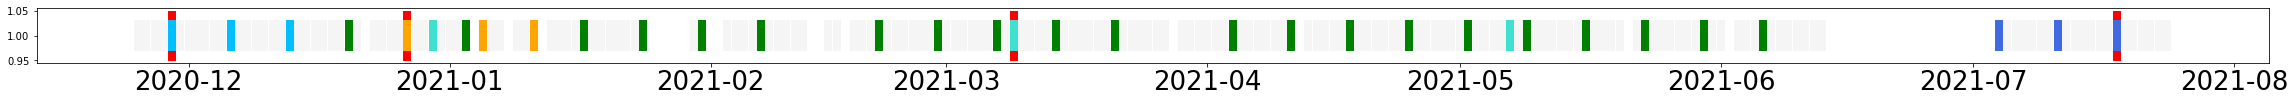

In [37]:
dico_c_color = {1:'red',
                0:'white',
                'LP10':'royalblue',
                'LP2':'deepskyblue',
                'time':'green',
                'TypicalVaccinationDay':'turquoise',
                'cold':'orange',
                'NotConsidered':'whitesmoke',
                'nomvtdata':'white'}
li_day = pd.date_range(start=df_daily['level'].min(), end=df_daily['level'].max(), freq = 'D')
dico_date_c = dict(zip(df_daily['level'].tolist(), df_daily['BS_type'].tolist()))
dico_date_ac = dict(zip(df_daily['level'].tolist(), df_daily['across_context'].tolist()))
dico_date_color = {}
for d in li_day:
    dico_date_color[d] = dico_c_color[dico_date_c.get(d,'nomvtdata')]
dico_date_colorac = {}
for d in li_day:
    dico_date_colorac[d] = dico_c_color[dico_date_ac.get(d,'nomvtdata')]
#plot
plt.figure(figsize=(40,1))
plt.scatter(dico_date_colorac.keys(), [1]*len(dico_date_colorac.keys()), color = list(dico_date_colorac.values()), 
            s=2500, marker='|',linewidths=8);
plt.scatter(dico_date_color.keys(), [1]*len(dico_date_color.keys()), color = list(dico_date_color.values()), 
            s=1000, marker='|',linewidths=8);
plt.xticks(fontsize=26)
plt.savefig(os.path.join(path_extracted_data_chapter2,'DaysSelected.png'), bbox_inches='tight')

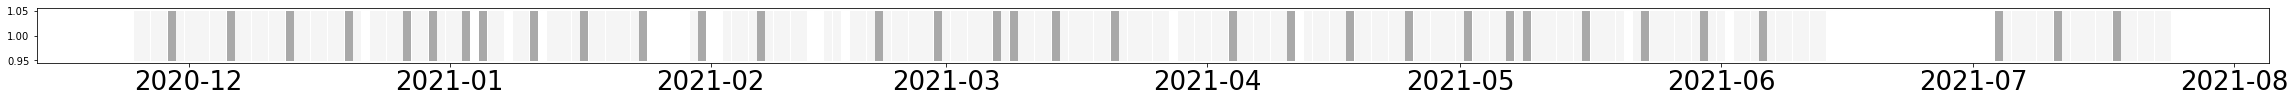

In [38]:
dico_c_color = {1:'darkgrey',
                0:'white',
                'LP10':'darkgrey',
                'LP2':'darkgrey',
                'time':'darkgrey',
                'TypicalVaccinationDay':'darkgrey',
                'cold':'darkgrey',
                'NotConsidered':'whitesmoke',
                'nomvtdata':'white'}
li_day = pd.date_range(start=df_daily['level'].min(), end=df_daily['level'].max(), freq = 'D')
dico_date_c = dict(zip(df_daily['level'].tolist(), df_daily['BS_type'].tolist()))
dico_date_ac = dict(zip(df_daily['level'].tolist(), df_daily['across_context'].tolist()))
dico_date_color = {}
for d in li_day:
    dico_date_color[d] = dico_c_color[dico_date_c.get(d,'nomvtdata')]
dico_date_colorac = {}
for d in li_day:
    dico_date_colorac[d] = dico_c_color[dico_date_ac.get(d,'nomvtdata')]
#plot
plt.figure(figsize=(40,1))
plt.scatter(dico_date_colorac.keys(), [1]*len(dico_date_colorac.keys()), color = list(dico_date_colorac.values()), 
            s=2500, marker='|',linewidths=8);
plt.scatter(dico_date_color.keys(), [1]*len(dico_date_color.keys()), color = list(dico_date_color.values()), 
            s=2500, marker='|',linewidths=8);
plt.xticks(fontsize=26)
plt.savefig(os.path.join(path_extracted_data_chapter2,'DaysSelected_B&W.png'), bbox_inches='tight')

In [39]:
#to add in PPWT
df_daily[df_daily['level'].isin([dt.datetime(2020,11,25),dt.datetime(2020,12,1),dt.datetime(2021,1,1),dt.datetime(2021,2,1),
                       dt.datetime(2021,3,1),dt.datetime(2021,4,1),dt.datetime(2021,4,1),dt.datetime(2021,5,1),
                                 dt.datetime(2021,6,1),dt.datetime(2021,7,24)])][['level','WIB','WOA']].drop_duplicates()

,level,WIB,WOA
0,2020-11-25,9,25
6,2020-12-01,9,26
36,2021-01-01,14,31
141,2021-03-01,22,39
171,2021-04-01,27,44
198,2021-05-01,31,48
257,2021-07-24,43,60
423,2021-06-01,35,52


In [40]:
print(df_daily['level'].min(), df_daily['level'].max())
print((df_daily['level'].max()-df_daily['level'].min()).days)
print((df_daily['level'].max()-df_daily['level'].min()).days/30)

2020-11-25 00:00:00 2021-07-24 00:00:00
241
8.033333333333333


# Save mvt for behavioural syndrome

In [41]:
display(df_daily['SleepingHeight'].value_counts(normalize=True))
display(df_daily['Sleeping_Uppest'].value_counts(normalize=True))

3.0    0.694217
1.0    0.162248
2.0    0.140806
0.0    0.002729
Name: SleepingHeight, dtype: float64

1    0.687605
0    0.312395
Name: Sleeping_Uppest, dtype: float64

In [42]:
dico_penid_penidfood = {'pen3':'FoodPenID1-4', 
                        'pen4':'FoodPenID1-4', 
                        'pen5':'FoodPenID5-8', 
                        'pen8':'FoodPenID5-8', 
                        'pen9':'FoodPenID9-12',
                        'pen10':'FoodPenID9-12', 
                        'pen11':'FoodPenID9-12', 
                        'pen12':'FoodPenID9-12', }
df_daily['FoodPenID'] = df_daily['PenID'].map(lambda x: dico_penid_penidfood[x])

In [43]:
len(df_daily[df_daily['level']>dt.datetime(2021,7,1)]['HenID'].unique())

153

In [44]:
#Z4: day after the VD and CET, like night: night that follow
li_Z4mvt = ['mid_cum_Z4_h_Morning'] #nbr_visit_Z4_Morning_more60sec
for mv in li_Z4mvt:
    #not efficient way, but easy
    df_daily[mv+'_dafter'] = df_daily.apply(lambda x: df_daily[(df_daily['HenID']==x['HenID'])&\
                                                               (df_daily['DIB']==x['DIB']+1)][mv].values, axis=1)
    df_daily[mv+'_dafter'] = df_daily[mv+'_dafter'].map(lambda x: x[0] if len(x)==1 else np.nan)
    display(df_daily[df_daily['BS_type'].isin(['cold','TypicalVaccinationDay'])][[mv+'_dafter',mv]].head(3))

,mid_cum_Z4_h_Morning_dafter,mid_cum_Z4_h_Morning
31,3.849722,3.791389
34,3.901389,4.036111
39,4.071667,3.975833


In [45]:
#replace the value to avoid having two columns depending on the context etc. would be annoying for the across contex too
for mv in li_Z4mvt:
    df_daily[mv] = np.where(df_daily['BS_type'].isin(['cold','TypicalVaccinationDay']), 
                                df_daily[mv+'_dafter'], #when condtion is trux
                                df_daily[mv])
    display(df_daily[df_daily['BS_type'].isin(['cold','TypicalVaccinationDay'])][[mv+'_dafter',mv]].head(3))

,mid_cum_Z4_h_Morning_dafter,mid_cum_Z4_h_Morning
31,3.849722,3.849722
34,3.901389,3.901389
39,4.071667,4.071667


In [46]:
print(list(df_daily.columns))

['HenID', 'level', 'verification_daily_total_duration', 'verification_daily_total_nbr_hour', 'dur_values', 'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone', 'perc_duration_2_Zone', 'perc_duration_1_Zone', 'time_wg_open_sec', 'duration_sincedaystarted_beforeWGopened_sec', 'perc_1_Zone_while_WG_open', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone', 'FirstTimestamp_4_Zone', 'FirstTimestamp_5_Zone', 'nbr_h_WGopen', 'FirstTimestamp_1_Zone_sec', 'latency_1_Zone_h', 'Total_number_zone', 'list_of_durations', 'nestboxes_related_behavior', 'mid_cum_Z4_sec', 'Total_number_transition', 'nbr_stays', 'distribution_entropy', 'vertical_travel_distance', 'vertical_travel_distance_dawn', 'vertical_travel_distance_dusk', 'nbr_stays_total', 'nbr_stays_3_Zone', 'nbr_stays_4_Zone', 'nbr_stays_5_Zone', 'nbr_stays_2_Zone', 'nbr_stays_1_Zone', 'PenID', 'CLASS', 'R-Pen', 'InitialStartDate', 'early_death', 'Treatment', 'TagID', 'FocalLegringName', 'night_level', '

#list of hen that always outside during LP10
df_ = df_BS[df_BS['BS_type']=='LP10'].groupby('HenID')['WentinWG'].agg(lambda x: list(x)).reset_index()
df_['alwaysWG'] = df_['WentinWG'].map(lambda x: sum(x)==len(x))
df_['nbrObs'] = df_['WentinWG'].map(lambda x: len(x))
display(df_.head(3))
li_hen_WG = df_[(df_['alwaysWG'])&(df_['nbrObs']<3)]['HenID'].tolist()
print(len(li_hen_WG))
print(li_hen_WG)
li_hen_WG = df_[df_['alwaysWG']]['HenID'].tolist()
print(len(li_hen_WG))
print(li_hen_WG)

In [47]:
df_daily['food_reactivity_index'] = df_daily['food_related_behavior_final'].map(lambda x: x*-1)
df_daily['food_reactivity_index_forward'] = df_daily['food_related_behavior_rp_final'].map(lambda x: x*-1)
df_daily['food_reactivity_index_backward'] = df_daily['food_related_behavior_rm_final'].map(lambda x: x*-1)

In [48]:
li_henselected = list(df_daily[df_daily['level']>dt.datetime(2021,7,1)]['HenID'].unique())
#&(df_daily['HenID'].isin(li_henselected))
df_BS = df_daily[(df_daily['BS_type']!='NotConsidered')][['TrackingSystemID','level','DOA','DIB','FoodPenID','BS_type','Treatment','CLASS','PenID',
                                                        'temperature_C_avg','HenID_WIB','HenID','across_context',
                                                        'KBF_interp','weight_interp',
                                                        'WentinWG','mid_cum_Z4_h_Morning','Sleeping_Uppest', 
                                                        'vertical_travel_distance_fulllight_perinsideh',
                                                         'food_sameDurTiming_r50_final', 'food_sameDurTiming_r50_AB_final',
                                                         'food_sameDurTiming_r50_AP_final']].copy()
#'latency_1_Zone_h','nbr_h_WGopen','perc_1_Zone_while_WG_open','FeatherDamage_interp','Has_been_toptier_wholeday'
#'nbr_visit_Z4_Morning_more60sec'
print(df_BS.shape)
df_BS = df_BS[~df_BS['mid_cum_Z4_h_Morning'].isnull()]
print(df_BS.shape)
#df_BS['nbr_visit_Z4_Morning_more60sec'] = df_BS['nbr_visit_Z4_Morning_more60sec'].map(lambda x: max(1,x))
#df_BS['nbr_visit_Z4_Morning_more60sec'] = df_BS['nbr_visit_Z4_Morning_more60sec'].map(lambda x: min(8,x))
print(df_BS.shape)
df_BS = df_BS[~df_BS['WentinWG'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['Sleeping_Uppest'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['vertical_travel_distance_fulllight_perinsideh'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['food_sameDurTiming_r50_final'].isnull()]
print(df_BS.shape)
df_BS = df_BS[~df_BS['KBF_interp'].isnull()] 
print(df_BS.shape)
df_BS = df_BS[~df_BS['weight_interp'].isnull()]
print(df_BS.shape)
df_BS = df_BS[df_BS['vertical_travel_distance_fulllight_perinsideh']!=0] #only one so we remove so that we can use a gamma without adding a cst
print(df_BS.shape)
#df_BS['AvgDay_PER CONTEXT'] = df_BS['HenID'].map(lambda x: dict(df_BS.groupby(['HenID'])['DIB'].agg(lambda x: np.mean(x)))[x])
#plt.hist(df_BS['AvgDay']);
#df_BS['latency_1_Zone_mn'] = df_BS['latency_1_Zone_h'].map(lambda x: round(x*60,0))
#df_BS['latency_1_Zone_mn_6h'] = df_BS['latency_1_Zone_mn'].map(lambda x: min(x,6*60))
#df_BS['latency_1_Zone_mn_3h'] = df_BS['latency_1_Zone_mn'].map(lambda x: min(x,3*60))
#display(df_BS[['latency_1_Zone_mn','latency_1_Zone_h','latency_1_Zone_mn_6h','latency_1_Zone_mn_3h']].head(5))
#print(df_BS.shape)
display(df_BS.groupby(['BS_type'])['WentinWG'].value_counts(normalize=True))
display(df_BS.groupby(['BS_type'])['Sleeping_Uppest'].value_counts(normalize=True))
df_BS.to_csv(os.path.join(path_extracted_data,'df_BS.csv'), index=False, sep=',')
df_BS.head(5)

(5084, 22)
(4908, 22)
(4908, 22)
(4908, 22)
(4908, 22)
(4908, 22)
(4908, 22)
(4893, 22)
(4893, 22)
(4892, 22)


BS_type                WentinWG
LP10                   1           0.815556
                       0           0.184444
LP2                    1           0.680258
                       0           0.319742
TypicalVaccinationDay  1           0.611111
                       0           0.388889
cold                   1           0.589744
                       0           0.410256
time                   1           0.685544
                       0           0.314456
Name: WentinWG, dtype: float64

BS_type                Sleeping_Uppest
LP10                   1                  0.595556
                       0                  0.404444
LP2                    1                  0.736052
                       0                  0.263948
TypicalVaccinationDay  1                  0.707265
                       0                  0.292735
cold                   1                  0.714744
                       0                  0.285256
time                   1                  0.705569
                       0                  0.294431
Name: Sleeping_Uppest, dtype: float64

,TrackingSystemID,level,DOA,DIB,FoodPenID,BS_type,Treatment,CLASS,PenID,temperature_C_avg,...,across_context,KBF_interp,weight_interp,WentinWG,mid_cum_Z4_h_Morning,Sleeping_Uppest,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AB_final,food_sameDurTiming_r50_AP_final
4,TrackingSystem 10-12,2020-11-29,179,61,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,1,0.0,1747.700000,1,4.028333,1,6.366423,0.62,-0.20,-0.19
11,TrackingSystem 10-12,2020-12-06,186,68,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,0,0.0,1766.016667,1,4.046389,1,5.418036,0.22,0.25,0.05
18,TrackingSystem 10-12,2020-12-13,193,75,FoodPenID9-12,LP2,TRAN,REXP,pen10,5.833333,...,0,0.0,1784.333333,1,3.921667,1,7.037298,0.39,-0.23,-0.25
25,TrackingSystem 10-12,2020-12-20,200,82,FoodPenID9-12,time,TRAN,REXP,pen10,5.500000,...,0,0.0,1802.650000,1,4.586944,1,5.288128,0.69,0.03,0.01
31,TrackingSystem 10-12,2020-12-27,207,89,FoodPenID9-12,cold,TRAN,REXP,pen10,-2.000000,...,1,0.0,1820.966667,1,3.849722,1,4.487554,0.67,0.12,0.09


In [49]:
df_BS.groupby(['HenID'])['level'].count().reset_index().sort_values(['level'])

,HenID,level
111,hen_219,7
0,hen_1,10
40,hen_146,10
133,hen_29,10
21,hen_126,10
...,...,...
58,hen_168,32
57,hen_167,32
138,hen_4,32
15,hen_119,32


In [50]:
#some numbers
print('number of hens with x days within each context')
df_ = df_BS[df_BS['BS_type']!='time'].groupby(['BS_type','HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
display(df_.head(3))
display(df_.groupby(['BS_type','#available days'])['HenID'].count().reset_index())

print('final list of days within each context')
df_info = df_BS.groupby('BS_type')['level'].agg(lambda x: sorted([dt.datetime.date(i) for i in set(x)])).reset_index()
df_info['nbr_days'] = df_info['level'].map(lambda x: len(x))
display(df_info)

print('number of hens with x days over time situation')
df_ = df_BS[df_BS['BS_type']=='time'].groupby(['HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
#display(df_.head(3))
#df_BS[df_BS['BS_type']=='time'].groupby(['level'])['HenID'].count().reset_index() #no days with small less than 112 ind.
display(df_.groupby(['#available days'])['HenID'].count().reset_index())

print('number of hens with x days across context situation')
df_ = df_BS[df_BS['across_context']==1].groupby(['HenID'])['level'].count().reset_index()
df_.rename(columns={'level':'#available days'}, inplace=True)
#display(df_.head(3))
display(df_.groupby(['#available days'])['HenID'].count().reset_index())

print('show columns with max amount of nan')
display(df_BS.isna().sum(axis=0).sort_values().tail(15))

number of hens with x days within each context


,BS_type,HenID,#available days
0,LP10,hen_10,3
1,LP10,hen_101,3
2,LP10,hen_102,3


,BS_type,#available days,HenID
0,LP10,2,6
1,LP10,3,146
2,LP2,2,2
3,LP2,3,154
4,TypicalVaccinationDay,1,36
5,TypicalVaccinationDay,2,39
6,TypicalVaccinationDay,3,118
7,cold,1,2
8,cold,2,155


final list of days within each context


,BS_type,level,nbr_days
0,LP10,"[2021-07-04, 2021-07-11, 2021-07-18]",3
1,LP2,"[2020-11-29, 2020-12-06, 2020-12-13]",3
2,TypicalVaccinationDay,"[2020-12-30, 2021-03-09, 2021-05-07]",3
3,cold,"[2020-12-27, 2021-01-05]",2
4,time,"[2020-12-20, 2021-01-03, 2021-01-17, 2021-01-2...",21


number of hens with x days over time situation


,#available days,HenID
0,4,4
1,5,14
2,6,1
3,7,2
4,8,15
5,12,6
6,13,12
7,14,4
8,15,2
9,16,11


number of hens with x days across context situation


,#available days,HenID
0,1,17
1,2,36
2,3,27
3,4,111


show columns with max amount of nan


KBF_interp                         0
across_context                     0
HenID                              0
HenID_WIB                          0
temperature_C_avg                  0
PenID                              0
CLASS                              0
Treatment                          0
BS_type                            0
FoodPenID                          0
DIB                                0
DOA                                0
level                              0
food_sameDurTiming_r50_AB_final    0
food_sameDurTiming_r50_AP_final    0
dtype: int64

In [51]:
df_ = df_BS.groupby(['HenID'])['Sleeping_Uppest'].agg(lambda x: sum(x)==0).reset_index()
display(df_.head(3))
#list of hens that never slept down
li__hen_remov = list(df_[df_['Sleeping_Uppest']]['HenID'].unique())
len(li__hen_remov)
df_BS_ = df_BS[~df_BS['HenID'].isin(li__hen_remov)].copy()

,HenID,Sleeping_Uppest
0,hen_1,False
1,hen_10,True
2,hen_101,False


# Visual observed behavior

In [52]:
df_BS = pd.read_csv(os.path.join(path_extracted_data,'df_BS.csv'), sep=',')
df_BS.head(3)
li_mvt_cont = ['vertical_travel_distance_fulllight_perinsideh','food_sameDurTiming_r50_final','mid_cum_Z4_h_Morning']
li_mvt_bin = ['WentinWG','Sleeping_Uppest']

### boxplot within each context

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,6.366423
1,LP2,vertical_travel_distance_fulllight_perinsideh,5.418036
2,LP2,vertical_travel_distance_fulllight_perinsideh,7.037298


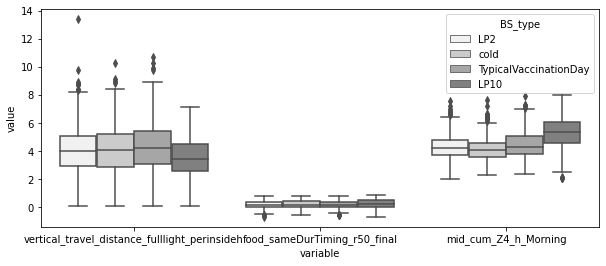

In [53]:
plt.figure(figsize=(10,4))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['TypicalVaccinationDay','cold','LP10','LP2'])].copy()
#df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', color='grey'); #fliersize=0.1, 
#plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,0.469712
1,LP2,vertical_travel_distance_fulllight_perinsideh,0.398221
2,LP2,vertical_travel_distance_fulllight_perinsideh,0.520283


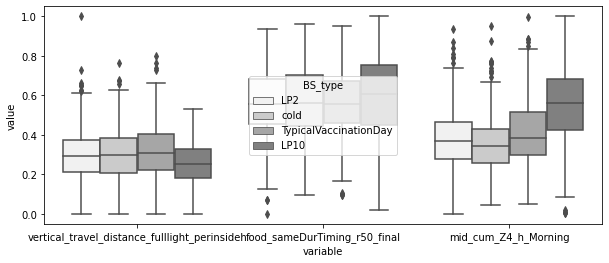

In [54]:
#normalised to have same y-axis between behaviors
plt.figure(figsize=(10,4))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['TypicalVaccinationDay','cold','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', color='grey'); #fliersize=0.1, 
#plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,BS_type,variable,value
0,LP2,vertical_travel_distance_fulllight_perinsideh,0.463700
1,LP2,vertical_travel_distance_fulllight_perinsideh,0.393124
2,LP2,vertical_travel_distance_fulllight_perinsideh,0.513624


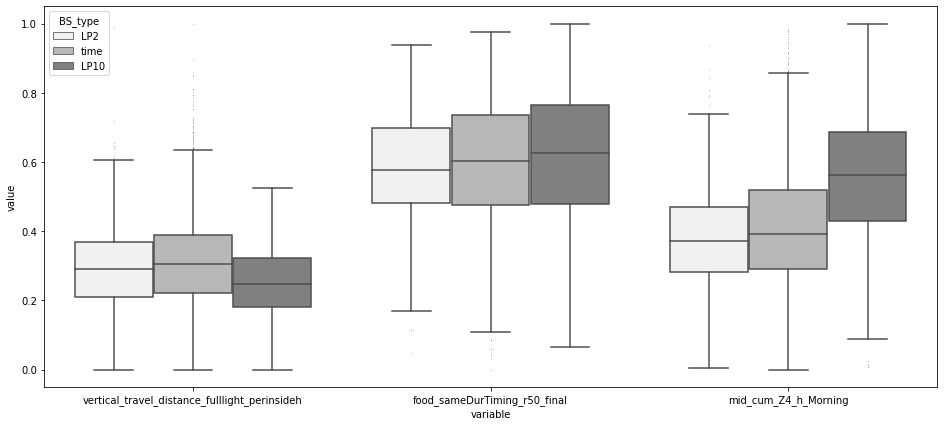

In [55]:
plt.figure(figsize=(16,7))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['BS_type'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="variable", y='value', data=df_plt, hue = 'BS_type', fliersize=0.1, color='grey');
plt.show();

### observed behavior over time

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


,DIB,variable,value
0,61,vertical_travel_distance_fulllight_perinsideh,0.463700
1,68,vertical_travel_distance_fulllight_perinsideh,0.393124
2,75,vertical_travel_distance_fulllight_perinsideh,0.513624


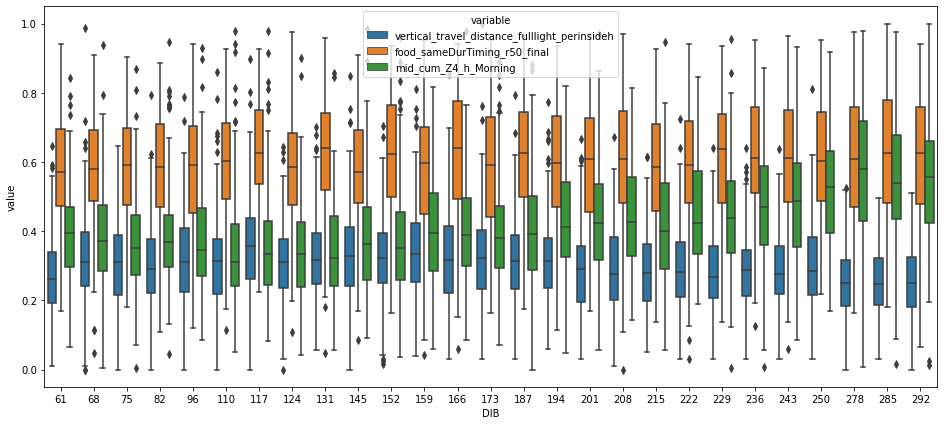

In [56]:
plt.figure(figsize=(16,7))
print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
df_plt[li_mvt_cont]=(df_plt[li_mvt_cont]-df_plt[li_mvt_cont].min())/(df_plt[li_mvt_cont].max()-df_plt[li_mvt_cont].min())
df_plt = pd.melt(df_plt, id_vars=['DIB'], value_vars=li_mvt_cont, value_name = 'value')
display(df_plt.head(3))
sns.boxplot(x="DIB", y='value', data=df_plt, hue = 'variable');
plt.show();

['LP2' 'time' 'cold' 'TypicalVaccinationDay' 'LP10']


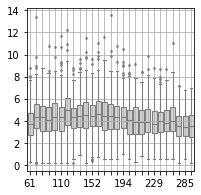

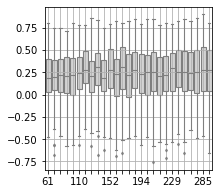

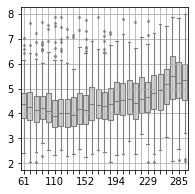

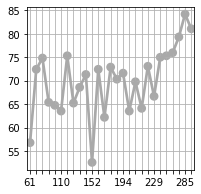

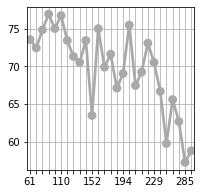

In [57]:
#continuous values 
dico_mvt_name = {'vertical_travel_distance_fulllight_perinsideh':'vertical travelled distance',
                 'food_sameDurTiming_r50_final': 'food reactivity index',
                 'mid_cum_Z4_h_Morning':'mid-timing nestbox usage',
                'WentinWG':'has been outside',
                 'Sleeping_Uppest':'has slept on upper tier'}


print(df_BS['BS_type'].unique())
df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
for m in li_mvt_cont:
    plt.figure(figsize=(3,3))
    ax = sns.boxplot(x="DIB", y=m, data=df_plt, color='lightgrey', fliersize=2, linewidth=1.1);
    plt.grid()
    #plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
    #ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #as we re missing some dates, we cant take all odd number for instance, we need to take one label over two
    ax.set_xticklabels([labels[i] if int(i)%5==0 else '' for i in range(0,len(labels))])
    #plt.xlabel('time (number of days in the laying barn)')
    #plt.ylabel(dico_mvt_name[m])
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(os.path.join(path_extracted_data ,'BS_'+m+'_overtime.png'), bbox_inches='tight')
    plt.show();
    
for m in li_mvt_bin:
    df_plt = df_BS[df_BS['BS_type'].isin(['time','LP10','LP2'])].copy()
    df_plt = df_plt.groupby(['DIB'])[m].mean().reset_index()
    df_plt[m] = df_plt[m].map(lambda x: 100*x) #into percentage
    plt.figure(figsize=(3,3))
    #print(df_plt.shape)
    #display(df_plt.head(3))
    ax = sns.pointplot(x="DIB", y=m, data=df_plt, color='darkgray');
    labels = [item.get_text() for item in ax.get_xticklabels()]
    #as we re missing some dates, we cant take all odd number for instance, we need to take one label over two
    ax.set_xticklabels([labels[i] if int(i)%5==0 else '' for i in range(0,len(labels))])
    plt.grid()
    #plt.xlabel('time (number of days in the laying barn)')
    #plt.ylabel(dico_mvt_name[m])
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig(os.path.join(path_extracted_data ,'BS_'+m+'_overtime.png'), bbox_inches='tight')
    plt.show();

### observed behaviour / hen

#### continuous mvt var

In [58]:
#initialise hens, list if mvt
#same color and different context (OR: coul dhave kept order and use no color, but we wouldn't illustratethe repeabtaitliy 
#within context)
#chose palette: https://seaborn.pydata.org/tutorial/color_palettes.html
df_ = df_BS[df_BS['across_context']==1].groupby(['HenID'])['level'].count().reset_index()
li_hen_plot = df_[df_['level']==4]['HenID'].tolist()
print('We will visualise the %d hens that are in all across_context observation (and thus also that are in all context at least one time)'%len(li_hen_plot))
#&(df_BS['PenID']=='pen10')
df_BS_plt = df_BS[(df_BS['HenID'].isin(li_hen_plot))][['level','DOA','DIB','BS_type','Treatment','PenID','HenID_WIB','HenID',
                                                       'across_context']+li_mvt_cont+li_mvt_bin].copy()

We will visualise the 111 hens that are in all across_context observation (and thus also that are in all context at least one time)


In [59]:
#dataframe to be able to sort hens by mean behavior over the time context only
df_plt = df_BS_plt[df_BS_plt['BS_type']=='time'].groupby(['HenID'])[li_mvt_cont+li_mvt_bin].median().reset_index()
print(df_plt.shape)
df_plt.head(3)

(111, 6)


,HenID,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final,mid_cum_Z4_h_Morning,WentinWG,Sleeping_Uppest
0,hen_10,3.043968,0.02,3.845833,0.0,0.0
1,hen_101,4.428296,0.41,4.537222,1.0,0.0
2,hen_102,2.747101,0.16,4.053333,1.0,1.0


In [60]:
#select 5 random hens and associate them to a nice color
random.seed(1)
li_all_hen = df_plt['HenID'].tolist()
li_hen_visual = random.choices(li_all_hen, k=5)
print(li_hen_visual)
pal_ = {henID:'grey' for henID in li_all_hen}
li_nicecolor_brighter = ['mediumblue','deeppink','goldenrod','green','cyan','yellow']
for i,henID in enumerate(li_hen_visual):
    pal_[henID] = li_nicecolor_brighter[i]

['hen_128', 'hen_7', 'hen_59', 'hen_151', 'hen_188']


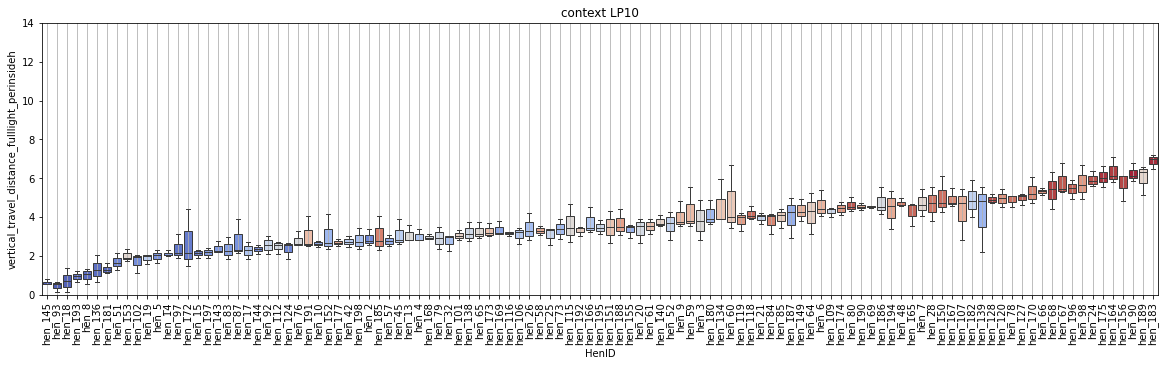

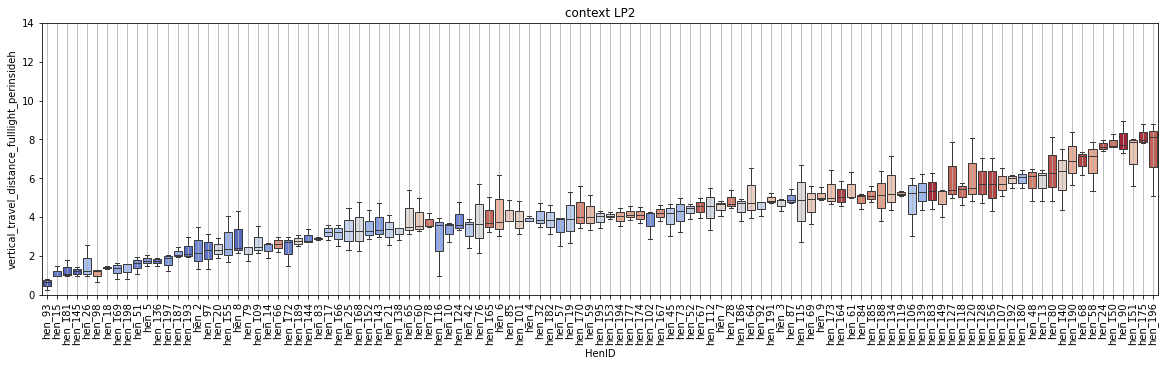

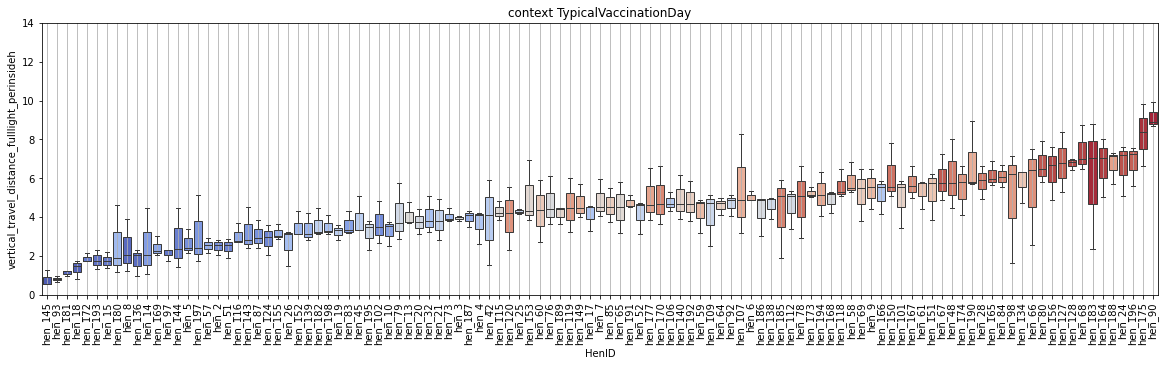

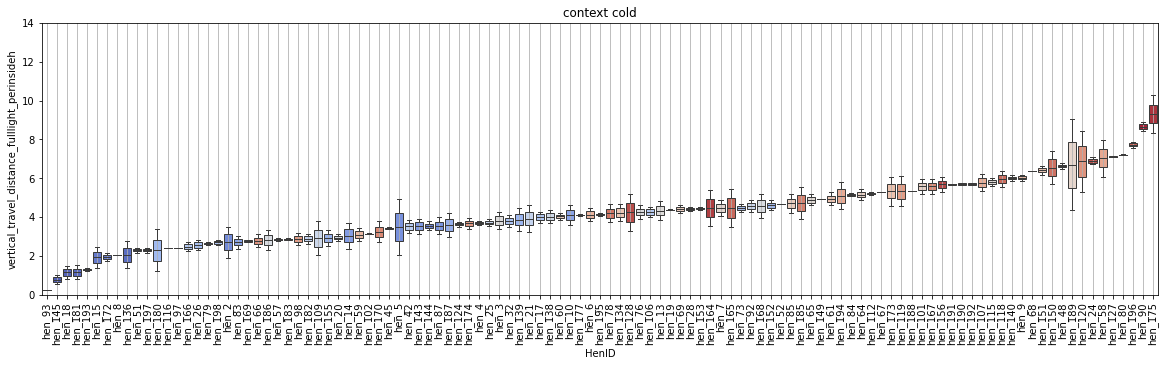

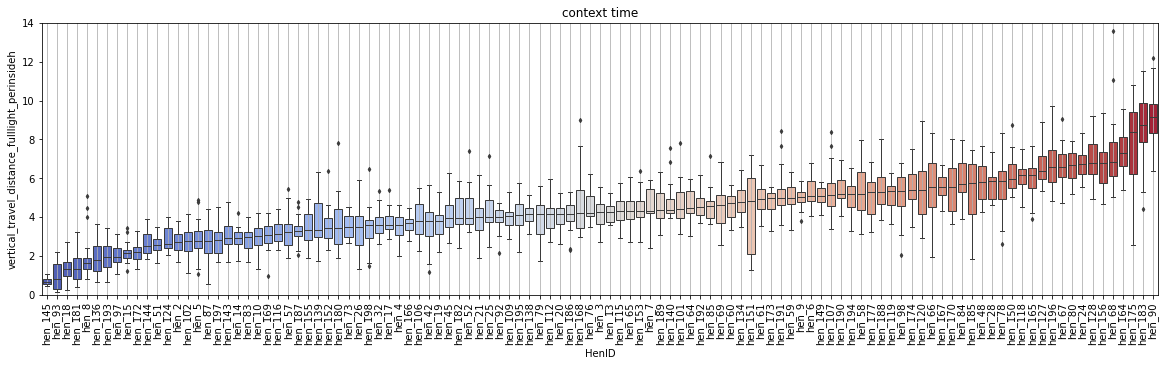

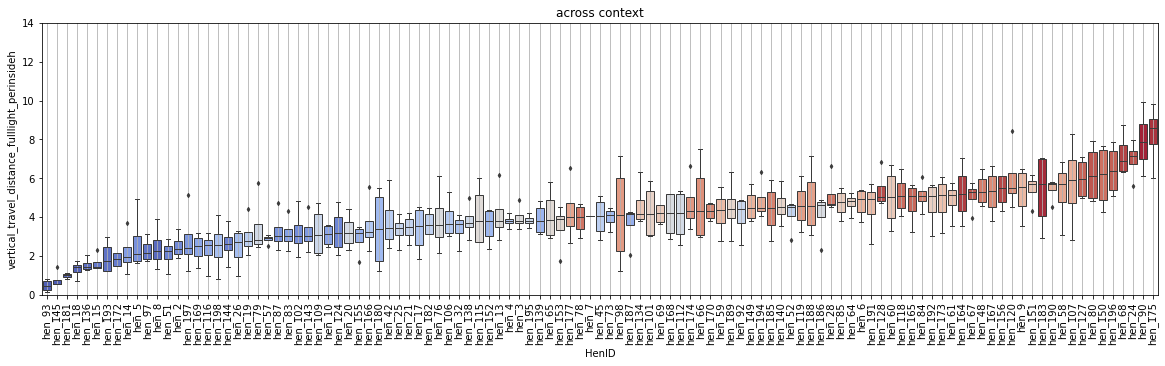

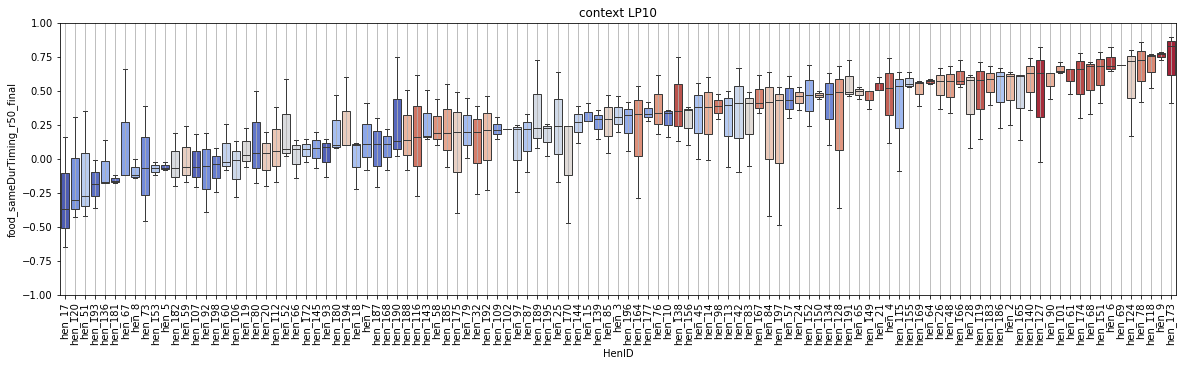

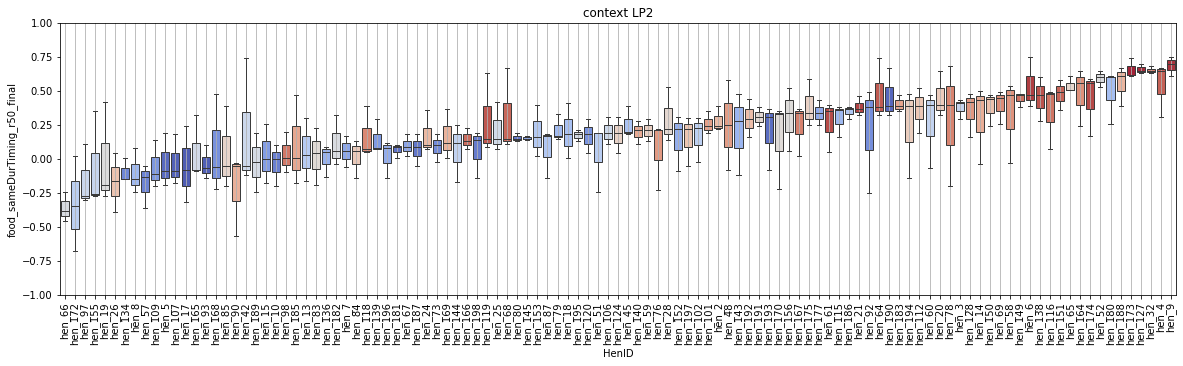

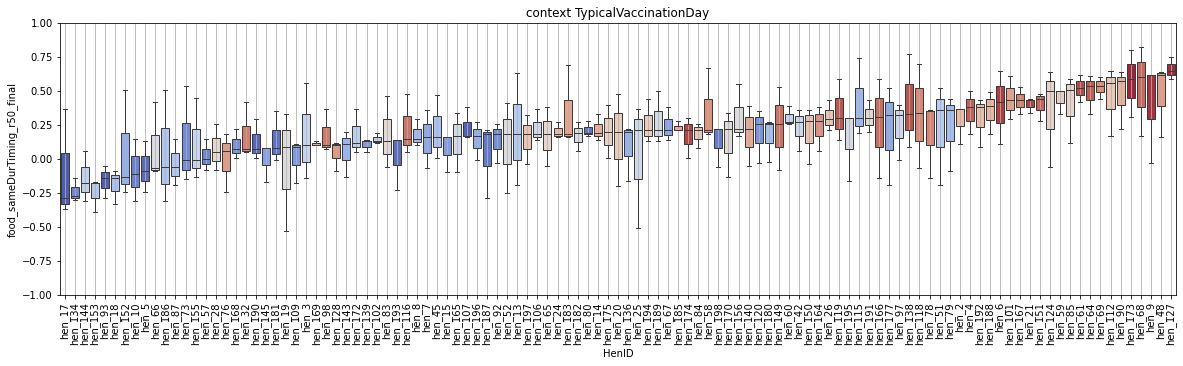

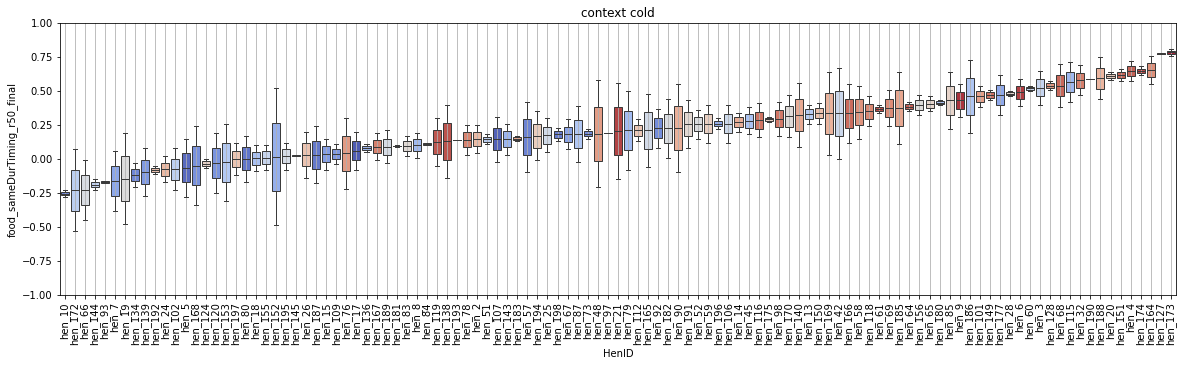

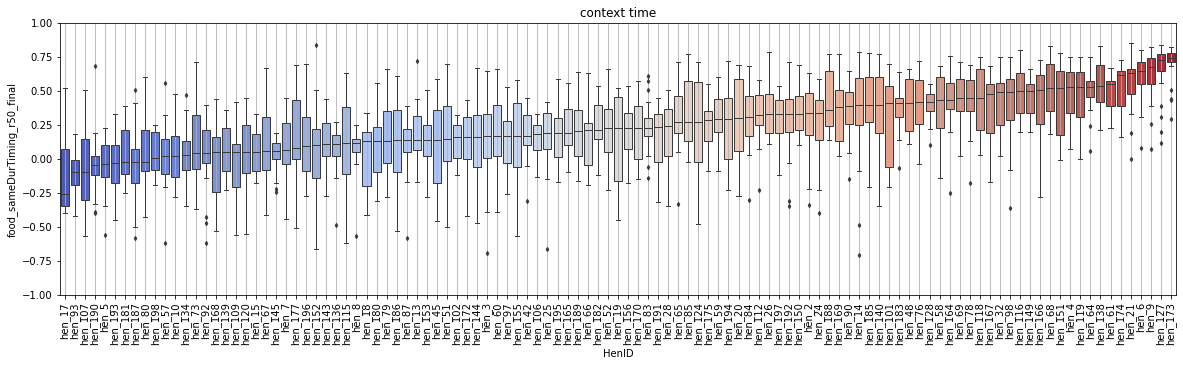

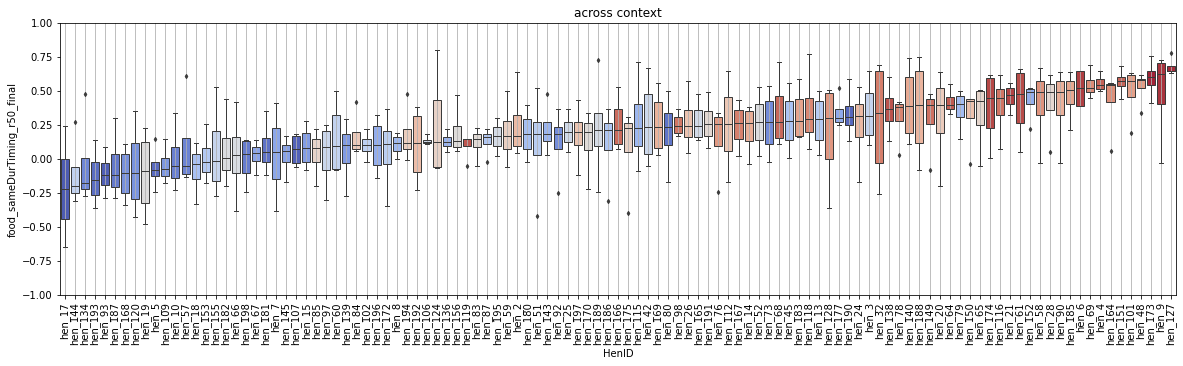

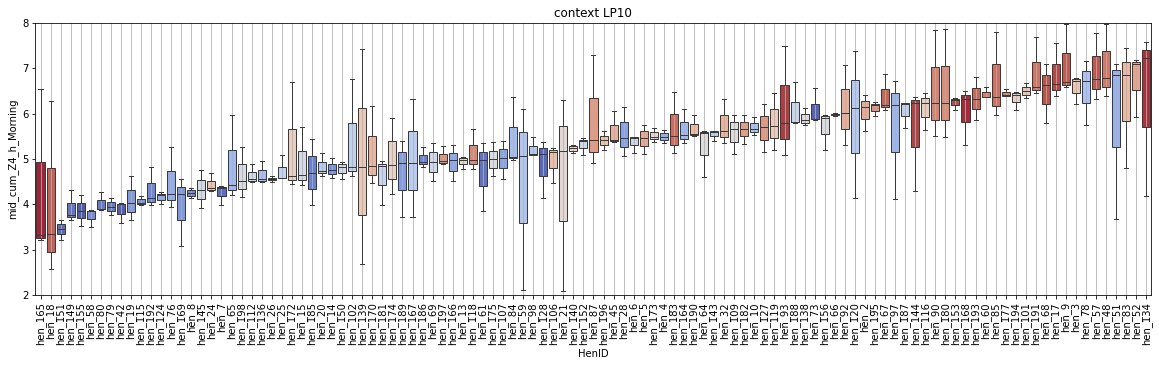

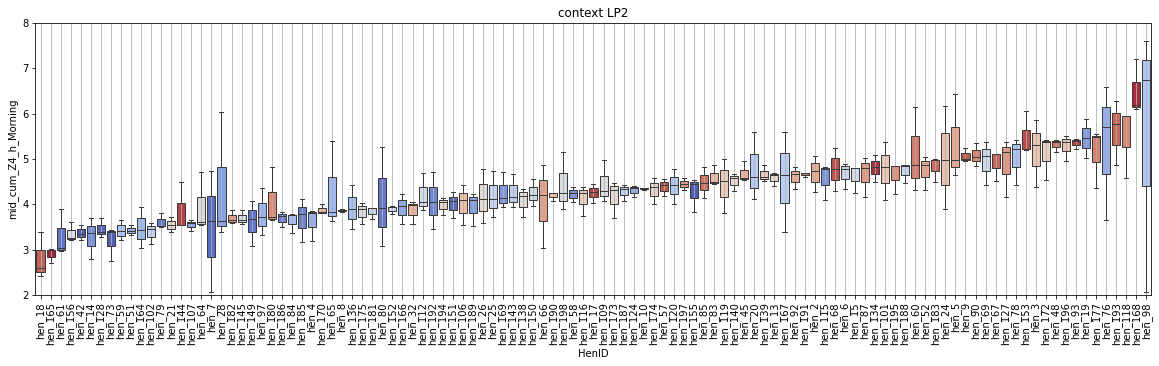

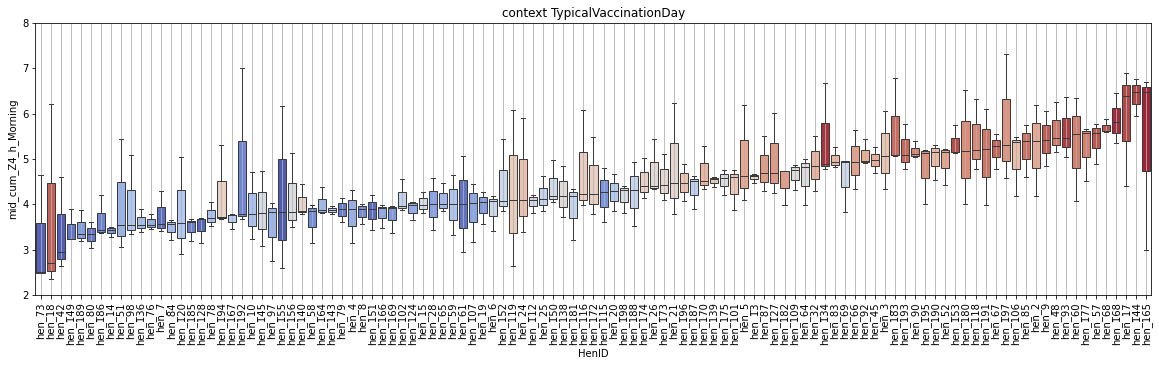

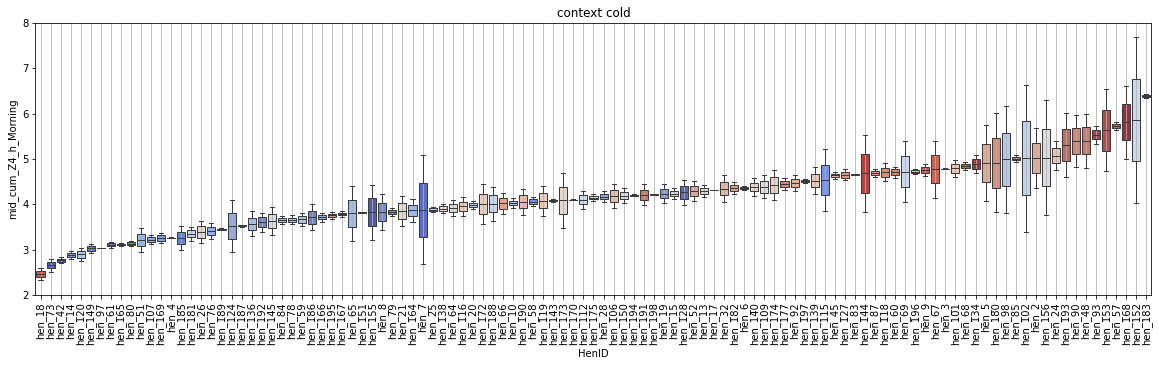

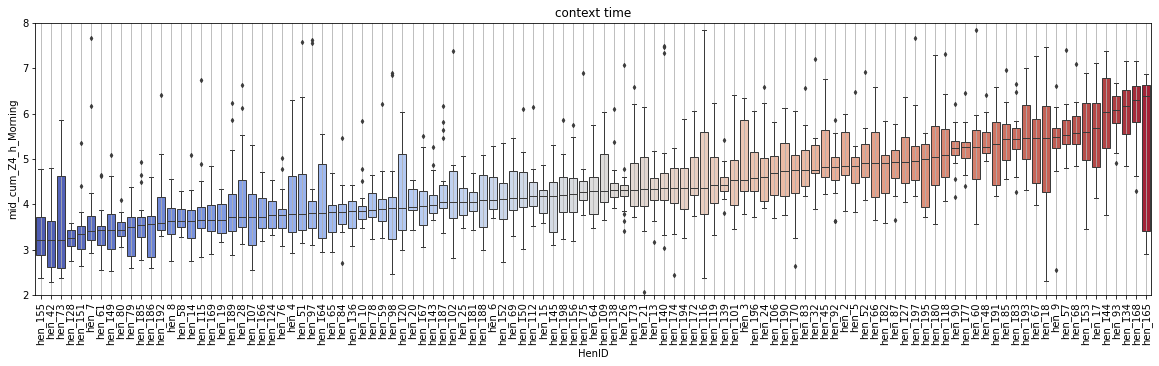

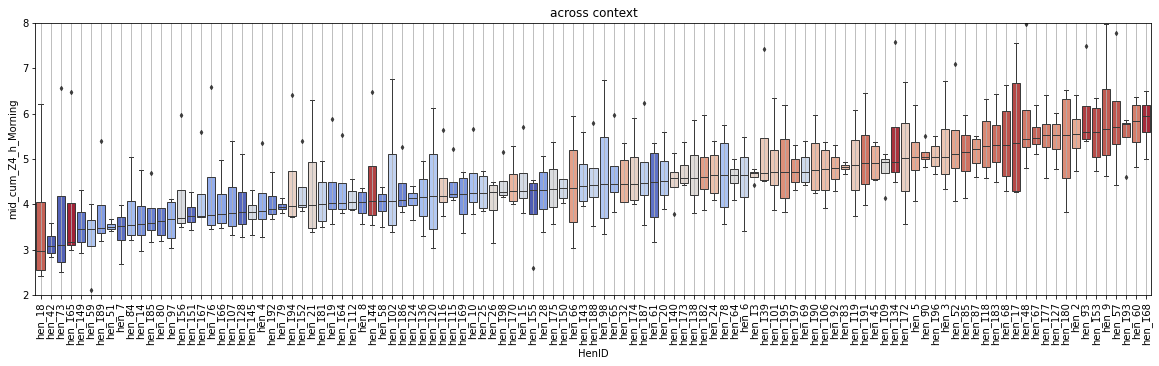

In [61]:
#dico_mvt_R = []
#'R = 0.38, 95%-CI [0.29, 0.44]'
#mvt = 'vertical_travel_distance_fulllight_perinsideh'
for mvt in li_mvt_cont:
    
    #choose color of hens based on the particular mvt variable, as sorted in the datafrmae based on the time context
    li_hen_sort = df_plt.sort_values([mvt])['HenID'].tolist()
    li_color = sns.color_palette("coolwarm",n_colors=len(df_plt['HenID'])) #flare, coolwarm,viridis
    df_plt = df_plt.sort_values(mvt)
    dico_hen_color =  dict(zip(df_plt['HenID'].tolist(), li_color))
        
    ### within context
    #for each context sort hens and plot with color as sorted by over time context
    for t, df_ in df_BS_plt.groupby(['BS_type']):
        #sort hens for that specific context based on the median to match the boxplot line
        df_plt_ = df_.groupby(['HenID'])[mvt].median().reset_index()
        li_hen_sort_ = df_plt_.sort_values([mvt])['HenID'].tolist()
        df_['sorted'] = df_['HenID'].map(lambda x: li_hen_sort_.index(x))
        df_ = df_.sort_values('sorted')
        plt.figure(figsize=(20,5))
        #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
        plt.grid()
        ax = sns.boxplot(x='HenID', y=mvt, data=df_, color='grey', palette=dico_hen_color, fliersize=3, linewidth=1);
        plt.grid()
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
        plt.title('context '+t)
        plt.ylim((math.floor(df_BS_plt[mvt].min()),math.ceil(df_BS_plt[mvt].max())))
        plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
        plt.show();

    ### across context
    df_ = df_BS_plt[df_BS_plt['across_context']==1].copy()
    df_plt_ = df_.groupby(['HenID'])[mvt].median().reset_index()
    li_hen_sort_ = df_plt_.sort_values([mvt])['HenID'].tolist()
    df_['sorted'] = df_['HenID'].map(lambda x: li_hen_sort_.index(x))
    df_ = df_.sort_values('sorted')
    plt.figure(figsize=(20,5))
    #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
    plt.grid()
    ax = sns.boxplot(x='HenID', y=mvt, data=df_, color='grey', palette=dico_hen_color, fliersize=3, linewidth=1);
    plt.grid()
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
    plt.title('across context')
    plt.ylim((math.floor(df_BS_plt[mvt].min()),math.ceil(df_BS_plt[mvt].max())))
    plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_acrosscontext.png'), bbox_inches='tight')
    plt.show();

#### Binary mvt var

In [62]:
#dataframe to be able to sort hens by mean behavior over the time context only
df_plt_binary = df_BS_plt[df_BS_plt['BS_type']=='time'].groupby(['HenID'])[li_mvt_bin].mean().reset_index()
df_plt_binary['Sleeping_Uppest_perc'] = df_plt_binary['Sleeping_Uppest'].map(lambda x: x*100)
print(df_plt_binary.shape)
df_plt_binary.head(3)

(111, 4)


,HenID,WentinWG,Sleeping_Uppest,Sleeping_Uppest_perc
0,hen_10,0.333333,0.000000,0.000000
1,hen_101,1.000000,0.476190,47.619048
2,hen_102,1.000000,0.952381,95.238095


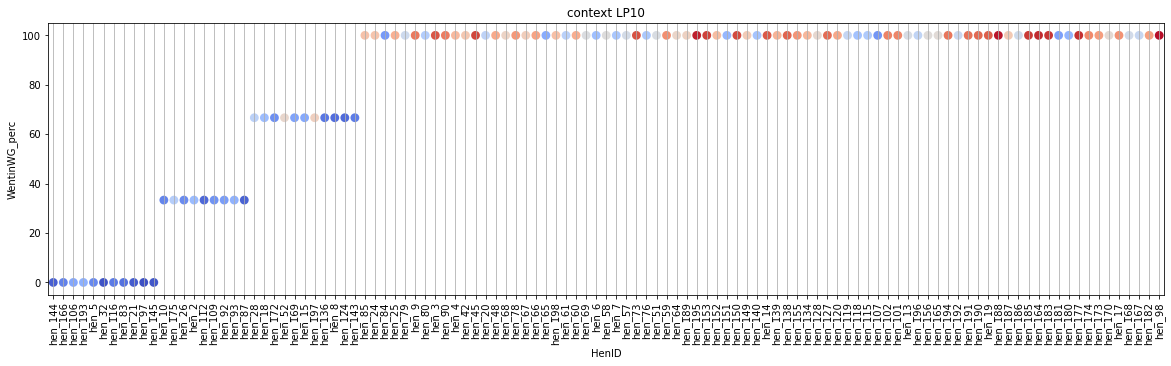

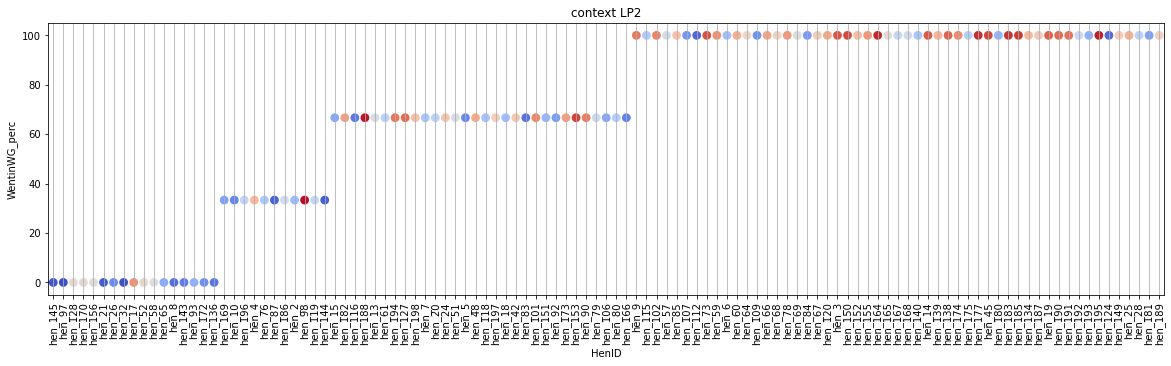

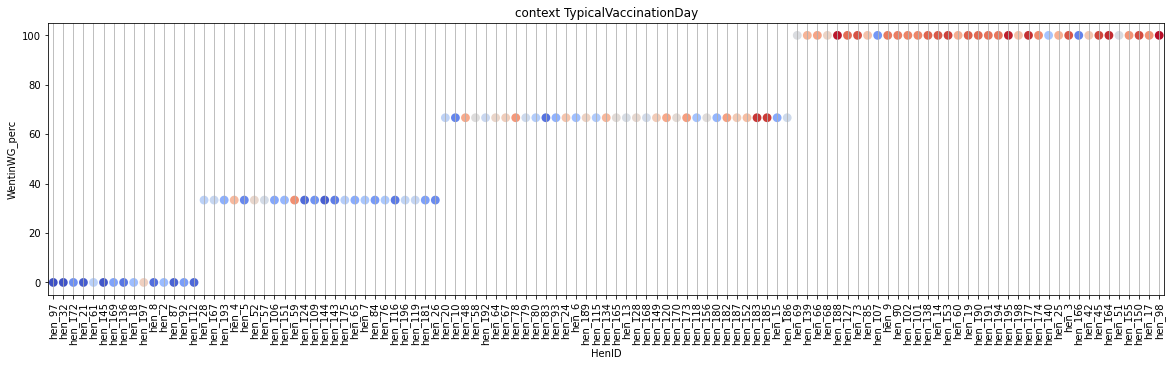

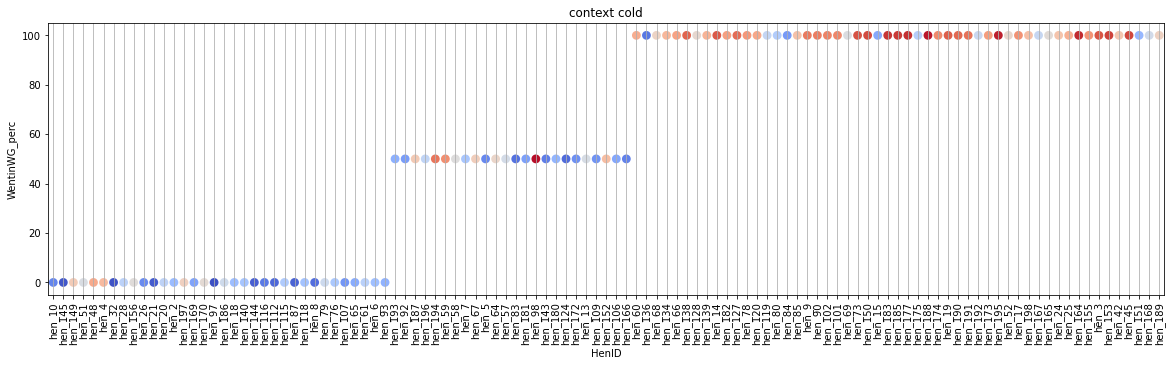

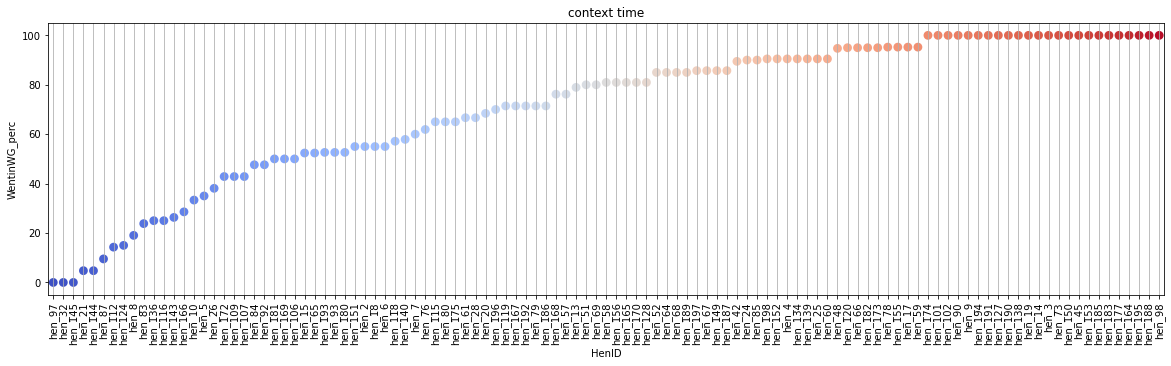

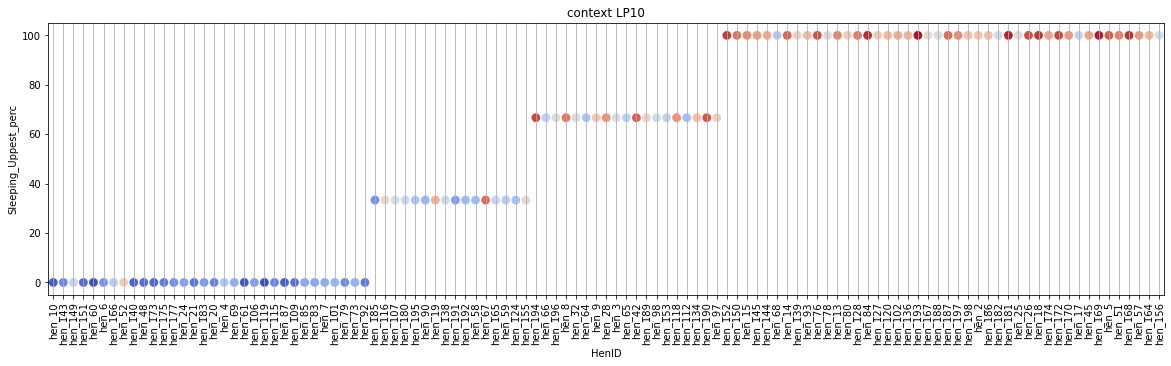

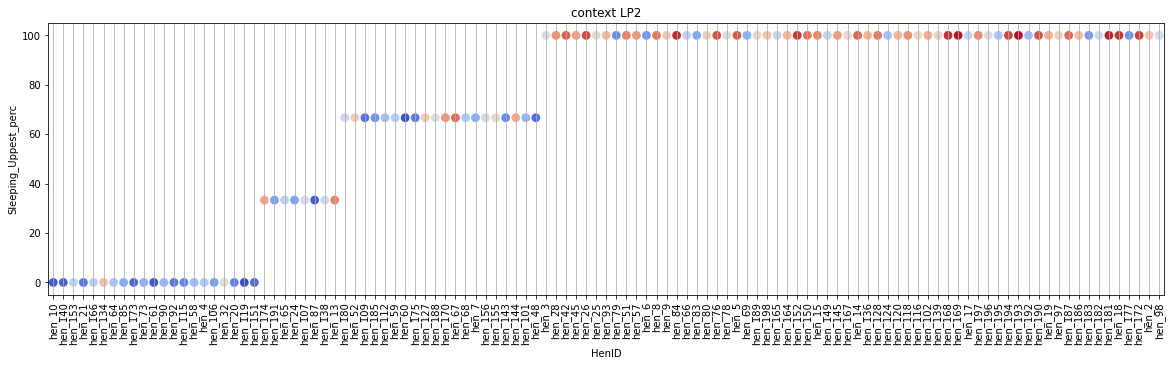

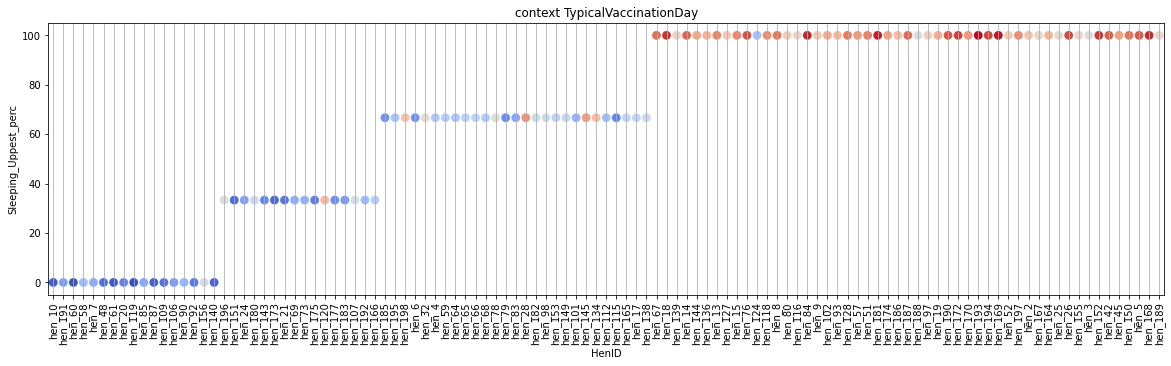

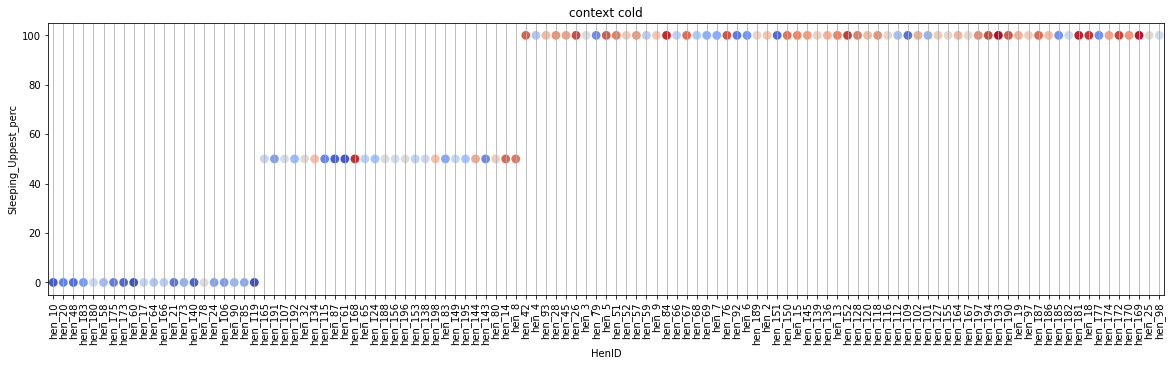

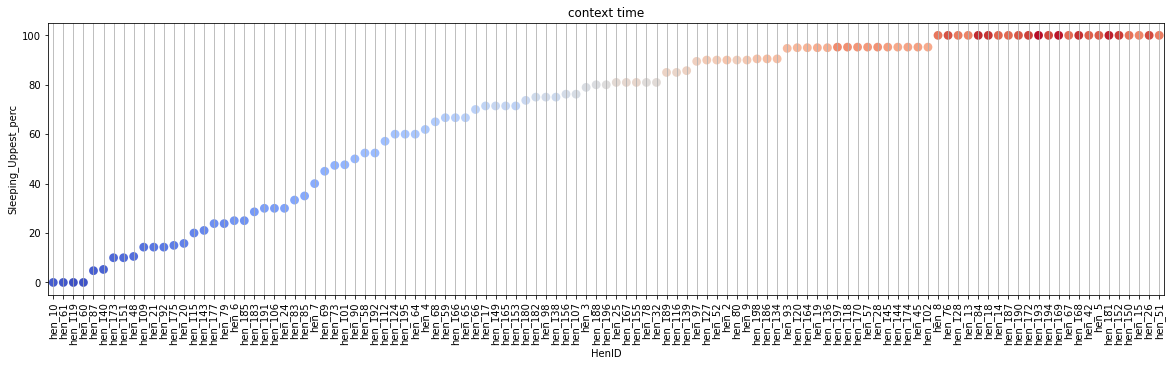

In [63]:
#dico_mvt_R = []
#'R = 0.38, 95%-CI [0.29, 0.44]'
#mvt = 'vertical_travel_distance_fulllight_perinsideh'
for mvt in li_mvt_bin:
    
    #choose color of hens based on the particular mvt variable, as sorted in the dataframe based on the time context
    li_hen_sort = df_plt_binary.sort_values([mvt])['HenID'].tolist()
    li_color = sns.color_palette("coolwarm",n_colors=len(df_plt_binary['HenID'])) #flare, coolwarm,viridis
    df_plt_binary = df_plt_binary.sort_values(mvt)
    dico_hen_color =  dict(zip(df_plt_binary['HenID'].tolist(), li_color))
    
    #for each context sort hens and plot with color as sorted by over time context
    for t, df_ in df_BS_plt.groupby(['BS_type']):
        #sort hens for that specific context
        df_plt_ = df_.groupby(['HenID'])[mvt].mean().reset_index()
        df_plt_[mvt+'_perc'] = df_plt_[mvt].map(lambda x: x*100)
        df_plt_ = df_plt_.sort_values([mvt+'_perc'])
        plt.figure(figsize=(20,5))
        #plt.text(2, 10.6, 'R = 0.38, 95%-CI [0.29, 0.44]', color='black', size='x-large')
        plt.grid()
        ax = sns.pointplot(x='HenID', y=mvt+'_perc', data=df_plt_, color='grey', palette=dico_hen_color);
        plt.grid()
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90);
        plt.title('context '+t)
        plt.savefig(os.path.join(path_extracted_data ,'BS_'+mvt+'_'+t+'.png'), bbox_inches='tight')
        plt.show();

# visualise behavior associations

--------------------------------------------------------------------------


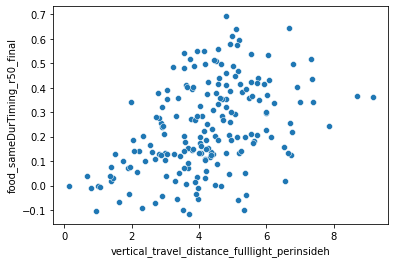

(0.438119941683154, 1.8648800139872463e-10)
SpearmanrResult(correlation=0.45749142108320245, pvalue=2.2519174601461614e-11)
--------------------------------------------------------------------------


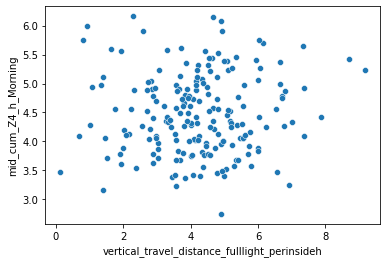

(0.05238675804755656, 0.4693424039437748)
SpearmanrResult(correlation=0.044043120025639655, pvalue=0.5430634042654332)
--------------------------------------------------------------------------


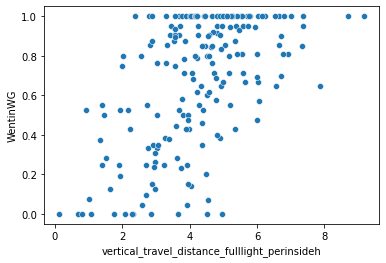

(0.5430021505877316, 3.4012074661946617e-16)
SpearmanrResult(correlation=0.5001755808210299, pvalue=1.2997724398493933e-13)
--------------------------------------------------------------------------


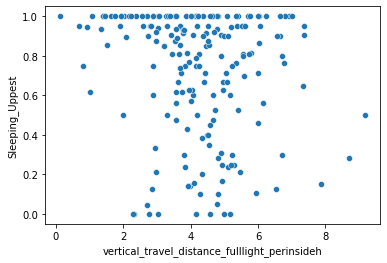

(-0.14561421103007965, 0.043323401066704334)
SpearmanrResult(correlation=-0.16394280113216583, pvalue=0.02271422313075936)
--------------------------------------------------------------------------


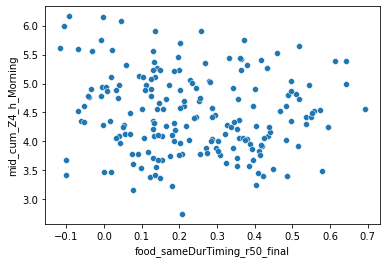

(-0.11211727159425758, 0.12057532289439865)
SpearmanrResult(correlation=-0.11047285355979933, pvalue=0.12615209029917188)
--------------------------------------------------------------------------


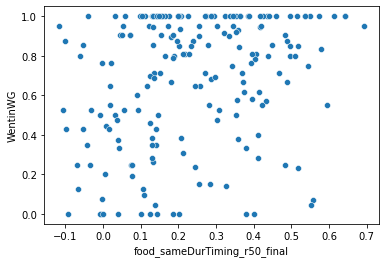

(0.27717611137581244, 9.525273644486909e-05)
SpearmanrResult(correlation=0.28176372489736545, pvalue=7.196642589105493e-05)
--------------------------------------------------------------------------


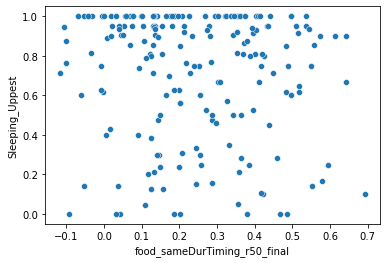

(-0.10323997300049621, 0.15307346285114343)
SpearmanrResult(correlation=-0.14387259714316725, pvalue=0.04591701295119092)
--------------------------------------------------------------------------


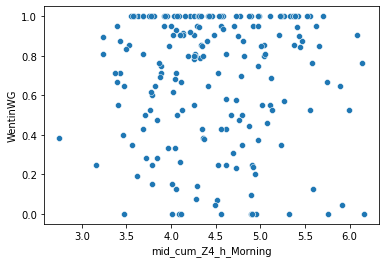

(-0.003506510886542741, 0.961399288571771)
SpearmanrResult(correlation=0.020941186414186085, pvalue=0.7725307948042914)
--------------------------------------------------------------------------


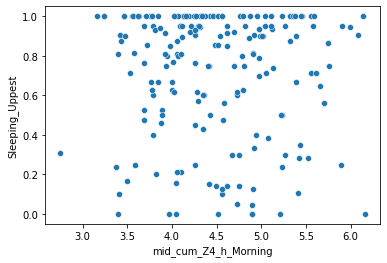

(-0.04282098636679728, 0.5543227588468551)
SpearmanrResult(correlation=-0.05481630826400379, pvalue=0.4489569812842503)
--------------------------------------------------------------------------


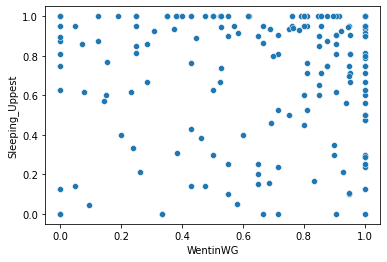

(0.08603096607783633, 0.23419447624322562)
SpearmanrResult(correlation=0.05740983513227937, pvalue=0.42775670951656486)


In [64]:
from scipy.stats import pearsonr, spearmanr
#in case but we are not studying this
#sns.scatterplot(data=df_BS.groupby(['HenID','BS_type']).mean().reset_index(), x="vertical_travel_distance_fulllight_perinsideh", 
#                y="food_related_behavior_final", hue='BS_type')
li_mvt = li_mvt_cont + li_mvt_bin
for i in range(0,len(li_mvt)-1):
    for j in range(i+1,len(li_mvt)):
        print('--------------------------------------------------------------------------')
        df_plt = df_BS[df_BS['BS_type']=='time'].groupby(['HenID']).mean().reset_index()
        sns.scatterplot(data=df_plt,
                        x=li_mvt[i],  y=li_mvt[j])#,  size="size", sizes=(20, 200))
        plt.show();
        print(pearsonr(df_plt[li_mvt[i]].tolist(), df_plt[li_mvt[j]].tolist()))
        print(spearmanr(df_plt[li_mvt[i]].tolist(), df_plt[li_mvt[j]].tolist()))

# visualise food reactivity index

In [65]:
df_BS = pd.read_csv(os.path.join(path_extracted_data,'df_BS.csv'), sep=',')
df_BS.head(3)

,TrackingSystemID,level,DOA,DIB,FoodPenID,BS_type,Treatment,CLASS,PenID,temperature_C_avg,...,across_context,KBF_interp,weight_interp,WentinWG,mid_cum_Z4_h_Morning,Sleeping_Uppest,vertical_travel_distance_fulllight_perinsideh,food_sameDurTiming_r50_final,food_sameDurTiming_r50_AB_final,food_sameDurTiming_r50_AP_final
0,TrackingSystem 10-12,2020-11-29,179,61,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,1,0.0,1747.700000,1,4.028333,1,6.366423,0.62,-0.20,-0.19
1,TrackingSystem 10-12,2020-12-06,186,68,FoodPenID9-12,LP2,TRAN,REXP,pen10,2.166667,...,0,0.0,1766.016667,1,4.046389,1,5.418036,0.22,0.25,0.05
2,TrackingSystem 10-12,2020-12-13,193,75,FoodPenID9-12,LP2,TRAN,REXP,pen10,5.833333,...,0,0.0,1784.333333,1,3.921667,1,7.037298,0.39,-0.23,-0.25


mean food reactivity index over all observations:


,variable,food_behavior
0,food_sameDurTiming_r50_AB_final,0.027837
1,food_sameDurTiming_r50_AP_final,0.019107
2,food_sameDurTiming_r50_final,0.233438


,HenID,level,PenID,variable,food_behavior,is_positive
0,hen_131,2020-11-29,pen10,food_sameDurTiming_r50_final,0.62,1
1,hen_131,2020-12-06,pen10,food_sameDurTiming_r50_final,0.22,1
2,hen_131,2020-12-13,pen10,food_sameDurTiming_r50_final,0.39,1


,variable,level,is_positive
0,food_sameDurTiming_r50_AB_final,2020-11-29,50.967742
1,food_sameDurTiming_r50_AB_final,2020-12-06,60.897436
2,food_sameDurTiming_r50_AB_final,2020-12-13,60.000000


,variable,mean_is_positive,sd_is_positive
0,food_sameDurTiming_r50_AB_final,53.702616,4.595321
1,food_sameDurTiming_r50_AP_final,52.056604,4.247170
2,food_sameDurTiming_r50_final,77.646092,3.509019


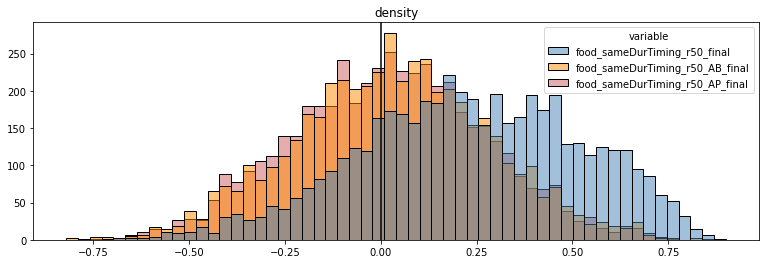

In [66]:
df_plt = pd.melt(df_BS, id_vars=['HenID','level','PenID'], 
        value_vars=['food_sameDurTiming_r50_final', 'food_sameDurTiming_r50_AB_final','food_sameDurTiming_r50_AP_final'],
        value_name='food_behavior')
print('mean food reactivity index over all observations:')
display(df_plt.groupby(['variable'])['food_behavior'].mean().reset_index())
df_plt['is_positive'] = df_plt['food_behavior'].map(lambda x: int(x>0))
display(df_plt.head(3))
df_plt_ = df_plt.groupby(['variable','level'])['is_positive'].agg(lambda x: sum(x)/len(x)*100).reset_index()
display(df_plt_.head(3))
display(df_plt_.groupby(['variable']).agg(mean_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.nanmean(x)),
           sd_is_positive=pd.NamedAgg(column='is_positive', aggfunc=lambda x: np.std(x))).reset_index())
#weekly average +-SD of the mean daily food-related behavior across individuals
plt.figure(figsize=(13,4))
pal_ = {'food_sameDurTiming_r50_AB_final':'darkorange',
        'food_sameDurTiming_r50_AP_final':'indianred',
        'food_sameDurTiming_r50_final':'steelblue'}
sns.histplot(df_plt, x='food_behavior', kde=False, hue='variable', palette=pal_);
plt.ylabel('')
plt.xlabel('')
plt.title('density')
plt.axvline(0, color='black');
plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_density.png'),dpi=300,format='png',bbox_inches='tight')

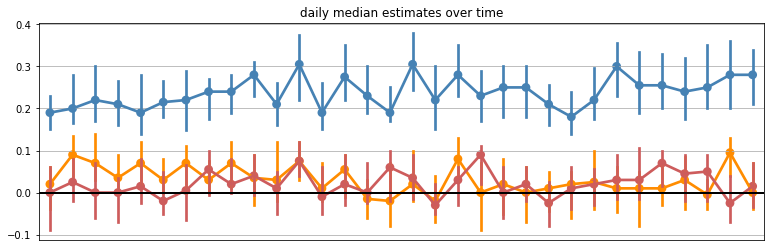

In [67]:
plt.figure(figsize=(13,4))
sns.pointplot(y='food_sameDurTiming_r50_final', x='DIB', color=pal_['food_sameDurTiming_r50_final'], data=df_BS, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AB_final', x='DIB', color=pal_['food_sameDurTiming_r50_AB_final'], data=df_BS, 
              estimator=np.median);
sns.pointplot(y='food_sameDurTiming_r50_AP_final', x='DIB', color=pal_['food_sameDurTiming_r50_AP_final'], data=df_BS, 
              estimator=np.median);
plt.axhline(y=0, linewidth=2, color = 'k')
plt.title('daily median estimates over time')
plt.xticks([])
plt.ylabel('')
plt.xlabel('')
plt.grid()
plt.savefig(os.path.join(path_extracted_data, 'dfBS_FoodRI_overtime_median.png'),dpi=300,format='png',bbox_inches='tight')

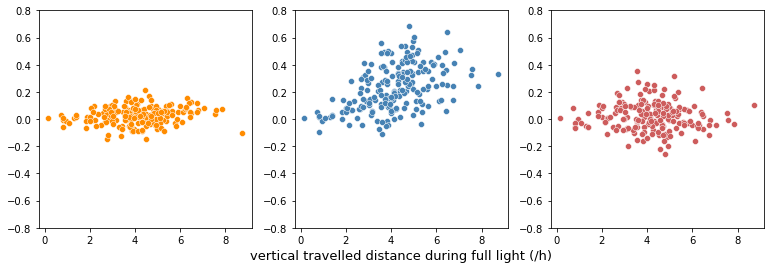

In [68]:
l=1
c=3
fig = plt.figure(figsize=(13,4)) #/100 si trop grand nbr
df_plt = df_BS.groupby(['HenID']).mean().reset_index()

plt.subplot(l,c,1)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AB_final',
                color=pal_['food_sameDurTiming_r50_AB_final'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('food reactivity index backward push')
plt.xlabel('')
plt.ylim((-0.8, 0.8))

plt.subplot(l,c,2)
#plt.figure(figsize=(5,4))
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_final',
                color=pal_['food_sameDurTiming_r50_final'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
plt.xlabel('vertical travelled distance during full light (/h)', size=13)
#plt.title('food reactivity index')
plt.yticks(fontsize=10)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))
plt.subplot(l,c,3)
sns.scatterplot(data=df_plt, x='vertical_travel_distance_fulllight_perinsideh', y='food_sameDurTiming_r50_AP_final',
                color=pal_['food_sameDurTiming_r50_AP_final'])#,  size="size", sizes=(20, 200))
plt.ylabel('')
#plt.title('hens\' mean value')
plt.xlabel('', size=13)
plt.ylim((-0.8, 0.8))

#plt.figure(figsize=(5,4))

plt.savefig(os.path.join(path_extracted_data,'dfBS_Raw_VTD_food.png'),dpi=300,format='png',bbox_inches='tight')
plt.show();

--------------------------------------------------------------------------


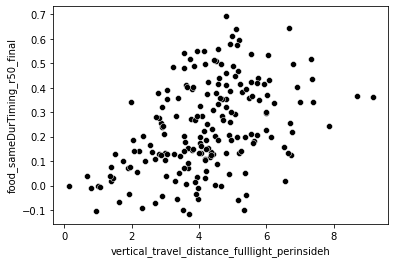

(0.438119941683154, 1.8648800139872463e-10)
SpearmanrResult(correlation=0.45749142108320245, pvalue=2.2519174601461614e-11)
--------------------------------------------------------------------------


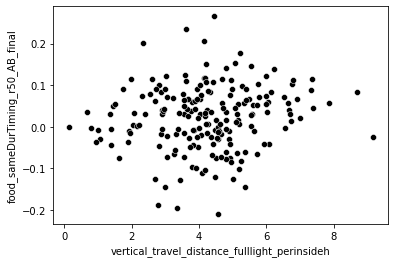

(0.12232769094803521, 0.09012062399785625)
SpearmanrResult(correlation=0.12404570755254117, pvalue=0.08566028256822814)
--------------------------------------------------------------------------


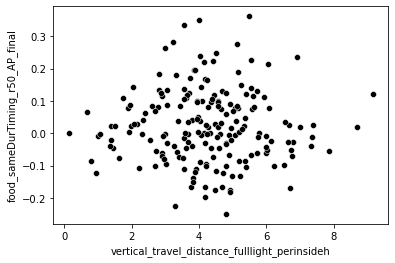

(-0.006162389097885846, 0.9322174115363913)
SpearmanrResult(correlation=-0.0369146870027306, pvalue=0.6102773627163082)
--------------------------------------------------------------------------


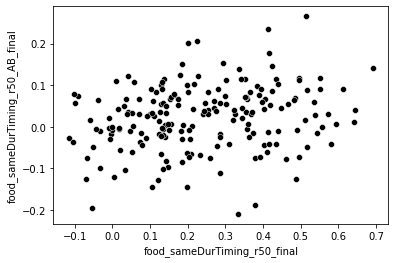

(0.2104643189515798, 0.0033049876135017734)
SpearmanrResult(correlation=0.20989153564033206, pvalue=0.0033932255436406344)
--------------------------------------------------------------------------


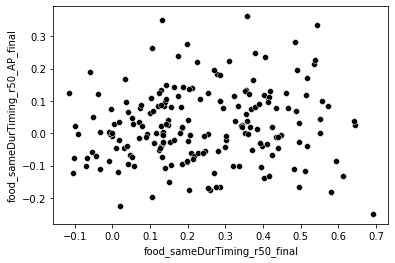

(0.10694738160228831, 0.13877774885858227)
SpearmanrResult(correlation=0.11902974408197092, pvalue=0.0992011608413078)
--------------------------------------------------------------------------


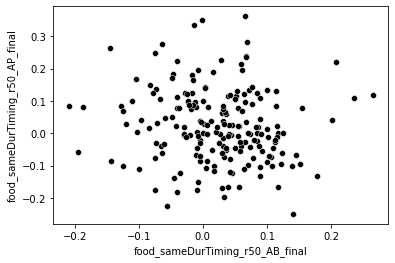

(-0.10674403425668319, 0.13953442458236817)
SpearmanrResult(correlation=-0.14566251243618686, pvalue=0.043253257837007064)


In [69]:
li_mvt_test = ['vertical_travel_distance_fulllight_perinsideh','food_sameDurTiming_r50_final',
               'food_sameDurTiming_r50_AB_final','food_sameDurTiming_r50_AP_final']
#in case but we are not studying this
#sns.scatterplot(data=df_BS.groupby(['HenID','BS_type']).mean().reset_index(), x="vertical_travel_distance_fulllight_perinsideh", 
#                y="food_related_behavior_final", hue='BS_type')
for i in range(0,len(li_mvt_test)-1):
    for j in range(i+1,len(li_mvt_test)):
        print('--------------------------------------------------------------------------')
        df_plt = df_BS[df_BS['BS_type']=='time'].groupby(['HenID']).mean().reset_index()
        sns.scatterplot(data=df_plt,
                        x=li_mvt_test[i], y=li_mvt_test[j], color='black')#,  size="size", sizes=(20, 200))
        plt.show();
        print(pearsonr(df_plt[li_mvt_test[i]].tolist(), df_plt[li_mvt_test[j]].tolist()))
        print(spearmanr(df_plt[li_mvt_test[i]].tolist(), df_plt[li_mvt_test[j]].tolist()))

# Available data - In words

In [70]:
mi = min(df_BS['DOA'].tolist())
ma = max(df_BS['DOA'].tolist())
print('We are involving a period of %d days of tracking during the days from the DOA %d until DOA %d'%(ma-mi, mi, ma))

We are involving a period of 231 days of tracking during the days from the DOA 179 until DOA 410


In [71]:
df_info = df_BS.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()
df_info['nbrDaysTracked'] = df_info['DOA'].map(lambda x: len(set(x)))
df_info = df_info.sort_values(['nbrDaysTracked'])
display(df_info.head(3))
#pen 5 had issues with batteries of markers!
df_info['nbrDaysTracked'].mean()

C:\Users\camil\AppData\Local\Temp/ipykernel_18688/2926827144.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_info = df_BS.groupby(['HenID'])['DOA','level','PenID'].agg(lambda x: list(x)).reset_index()


,HenID,DOA,level,PenID,nbrDaysTracked
111,hen_219,"[319, 333, 338, 340, 347, 354, 361]","[2021-04-18, 2021-05-02, 2021-05-07, 2021-05-0...","[pen10, pen10, pen10, pen10, pen10, pen10, pen10]",7
0,hen_1,"[179, 186, 193, 200, 207, 210, 214, 216, 228, ...","[2020-11-29, 2020-12-06, 2020-12-13, 2020-12-2...","[pen9, pen9, pen9, pen9, pen9, pen9, pen9, pen...",10
40,hen_146,"[179, 186, 193, 200, 207, 210, 214, 216, 228, ...","[2020-11-29, 2020-12-06, 2020-12-13, 2020-12-2...","[pen8, pen8, pen8, pen8, pen8, pen8, pen8, pen...",10


25.34715025906736

In [72]:
print('Hens had in average %d days tracked with a minimum of %d days tracked.'%(round(df_info['nbrDaysTracked'].mean(),0),
                                                                                df_info['nbrDaysTracked'].min()))

Hens had in average 25 days tracked with a minimum of 7 days tracked.


In [73]:
print('In other words, %d hens were used in subsequent analysis with a total of %d observations.'%(len(df_BS['HenID'].unique()),
                                                                                                   df_BS.shape[0]))

In other words, 193 hens were used in subsequent analysis with a total of 4892 observations.


# Available data - Visually

#heatmap of the hens, one row per hen: 1 means existing tracked day for the hen
df_plt = df_daily[['HenID', 'PenID', 'Treatment', 'CLASS','level','duration_5_Zone_min']].copy()
#dico_cl = {'EPI':'unknown', 'LEXP':'LEXP', 'MEXP':'MEXP', 'LEXPLOST':'unknown', 'MEXPLOST':'unknown','NewAfterEpi':'unknown', #'NewAfterEpiLOST':'unknown'}
#df_plt['CLASS'] = df_plt['CLASS'].map(lambda x: dico_cl[x])

#####find missing days
Daterange = pd.date_range(start = df_daily['level'].min(), end = df_daily['level'].max(), freq = 'D')    
li_missing_dates = [i for i in Daterange if i not in df_plt['level'].unique()]

#####add one row per missing dates for a random hen with duration_5_Zone_min beeing np.nan
x = df_plt.iloc[0]
df_missingdate = pd.DataFrame([{'level':d, 'duration_5_Zone_min':np.nan, 'HenID':x['HenID'], 'PenID':x['PenID'], 
                                'Treatment':x['Treatment'],'CLASS':x['CLASS']} for d in li_missing_dates])
print(df_plt.shape)
df_plt = df_plt.append(df_missingdate, ignore_index=True)
print(df_plt.shape)
df_plt['level'] = df_plt['level'].map(lambda x: dt.datetime.date(x))
df_plt.sort_values(['level'], inplace=True)
li_date = df_plt['level'].unique()

#####say if bird was tracked on taht day or not (i.e. we have his duration in zone 5)
df_plt['Tracked'] = df_plt['duration_5_Zone_min'].map(lambda x: int(not math.isnan(x)))
display(df_plt.head(3))
df_plt = df_plt.pivot(index=['HenID', 'PenID', 'Treatment', 'CLASS'], columns='level', values='Tracked').reset_index()
df_plt = df_plt.fillna(0)
df_plt.sort_values(['PenID'], inplace=True)
li_henorder = df_plt['HenID'].tolist()
print(df_plt.shape)
df_plt.head(3)

#per hens
fig = plt.figure(figsize=(15,30))
sns.heatmap(df_plt[li_date].to_numpy(), xticklabels=li_date,  yticklabels=df_plt['HenID'].tolist(), cmap="YlGnBu")
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerHens.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#per treatment
df_plt_summarized = df_plt.groupby(['Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['Treatment']+' - Pen '+str(x['PenID']), axis=1)
fig = plt.figure(figsize=(20,3))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per treatment')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerTreatment.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()

#per class
df_plt_summarized = df_plt.groupby(['CLASS','Treatment','PenID'])[li_date].sum().reset_index()
df_plt_summarized['name'] = df_plt_summarized.apply(lambda x: x['CLASS']+' - '+x['Treatment']+' - Pen '+str(x['PenID']), 
                                                    axis=1)
fig = plt.figure(figsize=(20,8))
sns.heatmap(df_plt_summarized[li_date].to_numpy(), xticklabels=li_date, 
            yticklabels=df_plt_summarized['name'].tolist(), cmap="YlGnBu", annot=True)
plt.title('Available data per class')
plt.savefig(os.path.join(path_extracted_data_chapter2,'DataPerClass.png'),dpi=300,format='png',bbox_inches='tight')
plt.show()